Imports

In [1]:
%pip install import-ipynb

Note: you may need to restart the kernel to use updated packages.


In [16]:
import import_ipynb
from Basic_Operations_Brisbane import*

Hamiltonian Tomography for the CR Gate

In [3]:
#Basic Params

backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f'Sampling time: {dt*1e9} ns')

Sampling time: 0.5 ns


In [4]:
print(backend_config.hamiltonian)

{'description': 'Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just |0> and |1>. The Pauli operators are generalized via the following set of transformations:\n\n$(\\mathbb{I}-\\sigma_{i}^z)/2 \\rightarrow O_i \\equiv b^\\dagger_{i} b_{i}$,\n\n$\\sigma_{+} \\rightarrow b^\\dagger$,\n\n$\\sigma_{-} \\rightarrow b$,\n\n$\\sigma_{i}^X \\rightarrow b^\\dagger_{i} + b_{i}$.\n\nQubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation subspace of the resonator buses leading to an effective qubit-qubit flip-flop interaction. The qubit resonance frequencies in the Hamiltonian are the cavity dressed frequencies and not exactly what is returned by the backend defaults, which also includes the dressing due to the qubit-qubit interactions.\n\nQuantities are returned in angular frequencies, with units 2*pi*GHz.\n\nWARNING: Currently not all system Hamiltonian information is available

In [336]:
control_qubit = 1
target_qubit = 0
    
inst_sched_map = backend_defaults.instruction_schedule_map 
cr_duration = 600
cr_sigma = 32
cr_square_width = 472
cr_risefall = (cr_duration - cr_square_width) / (2*cr_sigma)


In [101]:
print(qubit_frequency_data, qubit_pi_pulse_data)


[4409878671.792557, 4503147162.020036] [0.24687110574738982, 0.18366748619933454]


Pi Pulses for both Qubits

In [102]:
control_qbit_x12_freq = qubit_frequency_data[control_qubit]
control_qbit_pi_amp_12 = qubit_pi_pulse_data[control_qubit]

with pulse.build(backend) as cq_x12_gate:
    drive_chan = pulse.drive_channel(control_qubit)
    pulse.set_frequency(control_qbit_x12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=control_qbit_pi_amp_12,
                              sigma=x12_sigma,
                              name='x12'), drive_chan)
    
target_qbit_x12_freq = qubit_frequency_data[target_qubit]  
target_qbit_pi_amp_12 = qubit_pi_pulse_data[target_qubit]
with pulse.build(backend) as tq_x12_gate:
    drive_chan = pulse.drive_channel(target_qubit)
    pulse.set_frequency(target_qbit_x12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=target_qbit_pi_amp_12,
                              sigma=x12_sigma,
                              name='x12'), drive_chan)

Hadamard gate for both Qubits

In [103]:
with pulse.build(backend) as cq_h_gate:
    drive_chan = pulse.drive_channel(control_qubit)
    pulse.set_frequency(control_qbit_x12_freq, drive_chan)
    pulse.shift_phase(-np.pi/2, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=control_qbit_pi_amp_12/2,
                              sigma=x12_sigma,
                              name='h_12'), drive_chan)
    pulse.shift_phase(-np.pi/2, drive_chan)

with pulse.build(backend) as tq_h_gate:
    drive_chan = pulse.drive_channel(target_qubit)
    pulse.set_frequency(target_qbit_x12_freq, drive_chan)
    pulse.shift_phase(-np.pi/2, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=target_qbit_pi_amp_12/2,
                              sigma=x12_sigma,
                              name='h12'), drive_chan)
    pulse.shift_phase(-np.pi/2, drive_chan)

Sanity Check with CR Tomography on |0> and |1>

In [9]:
  
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
cr_pulse = inst_sched_map.get('ecr', (1, 0))
x_gate = inst_sched_map.get('x', (1))
print(cr_pulse)
print(x_gate)

Schedule((0, Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.03834986227101661, angle=0.011333164096987845, name='CR90p_d0_u2'), DriveChannel(0), name='CR90p_d0_u2')), (0, Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.16892515723960685, angle=-1.9526833287157388, name='CR90p_u2'), ControlChannel(2), name='CR90p_u2')), (600, Play(Drag(duration=120, sigma=30, beta=0.0851741687257881, amp=0.1874655203975036, angle=0.0, name='Xp_d1'), DriveChannel(1), name='Xp_d1')), (720, Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.03834986227101661, angle=-3.1302594894928055, name='CR90m_d0_u2'), DriveChannel(0), name='CR90m_d0_u2')), (720, Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.16892515723960685, angle=1.1889093248740543, name='CR90m_u2'), ControlChannel(2), name='CR90m_u2')), name="ecr")
Schedule((0, Play(Drag(duration=120, sigma=30, beta=0.0851741687257881, amp=0.1874655203975036, angle=0.0, name='Xp_d1'), DriveChannel(1), name='Xp_d1'

In [10]:
def test_cr_pulse(control_in_two, cr_duration, cr_width):
    with pulse.build(backend=backend, name='CR amp sweep') as cr_sched:
        u_chan = pulse.control_channels(control_qubit, target_qubit)[0]
        target_chan = pulse.DriveChannel(target_qubit)
        control_chan = pulse.DriveChannel(control_qubit)
        pulse.set_frequency(control_qbit_x12_freq, control_chan)
        pulse.set_frequency(target_qbit_x12_freq, target_chan)
        pulse.set_frequency(target_qbit_x12_freq, u_chan)
        with pulse.align_sequential():
            if control_in_two:
                pulse.call(cq_x12_gate)
            with pulse.align_left():
                pulse.play(pulse.GaussianSquare(duration=cr_duration,
                                        amp=0.03834986227101661, angle = 0.018276575418415493,
                                        sigma=cr_sigma, width = cr_width,
                                        name='cr_pulse'), target_chan)
                
                pulse.play(pulse.GaussianSquare(duration=cr_duration,
                                    amp=0.16963801287450686, angle = -1.945739917394311,
                                    sigma=cr_sigma, width = cr_width,
                                    name='cr_pulse'), u_chan)                     
            pulse.call(cq_x12_gate)
            with pulse.align_right():
                pulse.play(pulse.GaussianSquare(duration=cr_duration,
                                    amp= -0.03834986227101661, angle = 0.018276575418415493,
                                    sigma=cr_sigma, width = cr_width,
                                    name='cr_pulse'), target_chan)

                pulse.play(pulse.GaussianSquare(duration=cr_duration,
                                    amp= -0.16963801287450686, angle = -1.945739917394311,
                                    sigma=cr_sigma, width = cr_width,
                                    name='cr_pulse'), u_chan)
            pulse.call(cq_x12_gate)
    return cr_sched

In [11]:
def build_cr_scheds(qc: int, qt: int, cr_times, phase = 0.0, ZI_MHz = 0.0) -> np.array:
    """Build an array of cross resonance schedules for the Hamiltonian tomography experiment.
    
    Args:
      qc: control qubit index
      qt: target qubit index
      cr_times: array of widths of the cross resonance pulses
      phase: phase offset of the cross resonance pulse (rad)
      ZI_MHz: ZI interaction rate (in MHz) to correct for with frame change
    """
    tomo_circs = []
    
    cr_gate = Gate('cr', num_qubits = 2, params = []) 
    for width in cr_times:
        cr_duration = int(width + 2 * cr_risefall * cr_sigma)
        framechange = 2 * np.pi * int(width) * dt * ZI_MHz * 1e6
                
        for basis in ['X', 'Y', 'Z']:
            for control in ['1', '2']:
                control_in_two = False
                tomo_circ = QuantumCircuit(2,2)  #use all qubits to avoid error
                tomo_circ.x(0)
                tomo_circ.x(1)
                if control == '2':
                    control_in_two = True# flip control from |0> to |1>
                cr_sched = test_cr_pulse(control_in_two, cr_duration, width)
                tomo_circ.append(cr_gate, [qc, qt])  #apply custom cr_gate
                tomo_circ.rz(-framechange, qc)  #apply frame change on the qc
                tomo_circ.barrier(qc, qt)
                if basis == 'X':
                    tomo_circ.h(qt)
                elif basis == 'Y':
                    tomo_circ.sdg(qt)
                    tomo_circ.h(qt)
                tomo_circ.measure(qc,qc)
                tomo_circ.measure(qt,qt)  
                tomo_circ.add_calibration(gate=cr_gate, qubits=[qc, qt], schedule=cr_sched)
                tomo_circs.append(tomo_circ)
                
    tomo_circs_transpiled = transpile(tomo_circs, backend, optimization_level = 1)            
    return tomo_circs_transpiled, schedule(tomo_circs_transpiled, backend)

[   0.  208.  416.  624.  832. 1040. 1248. 1456. 1664. 1872. 2080. 2288.
 2496. 2704. 2912. 3120.]
96


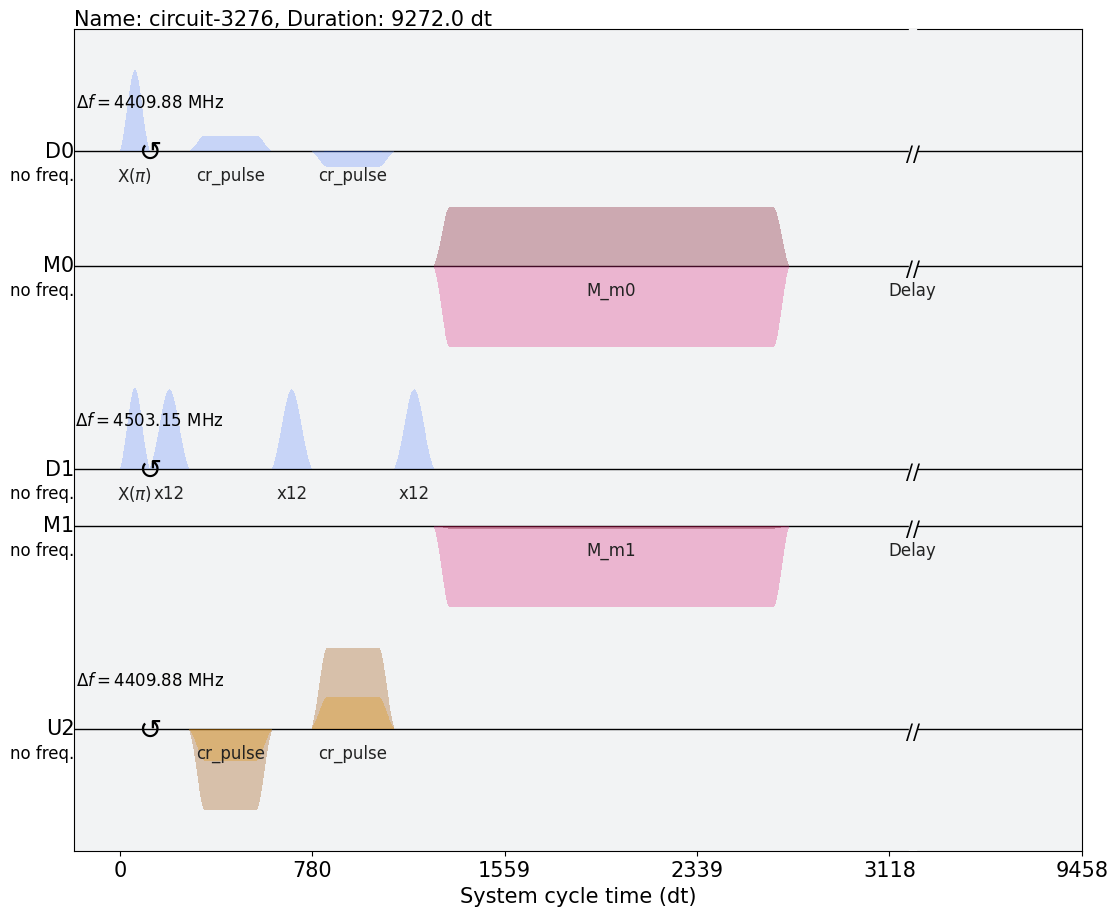

In [662]:
cr_times = 16*np.linspace(0,195,16)
print(cr_times)
exp_cr_tomo_circs, cr_scheds = build_cr_scheds(control_qubit, target_qubit, cr_times)
print(len(exp_cr_tomo_circs))
cr_scheds[11].draw()

In [13]:
# cr_tomo_job = backend.run(exp_cr_tomo_circs, meas_level=1, meas_return = 'single', shots = 1024)

In [14]:
cr_gate_freq = 4.4104932608213465*GHz

In [15]:
sweep_freqs = cr_gate_freq + np.linspace(-30*MHz, 30*MHz, 50)
freq = Parameter('freq')

with pulse.build(backend=backend, name='CR amp sweep') as cr_sched:
    u_chan = pulse.control_channels(control_qubit, target_qubit)[0]
    target_chan = pulse.DriveChannel(target_qubit)
    control_chan = pulse.DriveChannel(control_qubit)
    pulse.set_frequency(control_qbit_x12_freq, control_chan)
    pulse.set_frequency(target_qbit_x12_freq, target_chan)
    pulse.set_frequency(freq, u_chan)
    with pulse.align_sequential():
        with pulse.align_left():
            # pulse.play(pulse.GaussianSquare(duration=cr_duration,
            #                         amp=cr_amp,
            #                         sigma=cr_sigma, width = cr_square_width,
            #                         name='cr_pulse'), target_chan)
                
            pulse.play(pulse.GaussianSquare(duration=cr_duration,
                                amp=cr_amp, angle = 0,
                                sigma=cr_sigma, width = cr_square_width,
                                name='cr_pulse'), u_chan)                     
        pulse.call(cq_x12_gate)
        with pulse.align_right():
            # pulse.play(pulse.GaussianSquare(duration=cr_duration,
            #                     amp= -cr_amp,
            #                     sigma=cr_sigma, width = cr_square_width,
            #                     name='cr_pulse'), target_chan)

            pulse.play(pulse.GaussianSquare(duration=cr_duration,
                                amp= -cr_amp, angle = 0,
                                sigma=cr_sigma, width = cr_square_width,
                                name='cr_pulse'), u_chan)
        pulse.call(cq_x12_gate)

NameError: name 'cr_amp' is not defined

In [ ]:
cr_sweep_gate = Gate('cr_test', 2, [freq])
circ = QuantumCircuit(2,2)
circ.x(control_qubit)
circ.x(target_qubit)
circ.append(cr_sweep_gate, [control_qubit,target_qubit])
circ.measure(control_qubit, control_qubit)
circ.measure(target_qubit,target_qubit)
circ.add_calibration(cr_sweep_gate, (control_qubit,target_qubit), cr_sched, [freq])

exp_cr_sweep_circs = [circ.assign_parameters({freq: f}) for f in sweep_freqs]

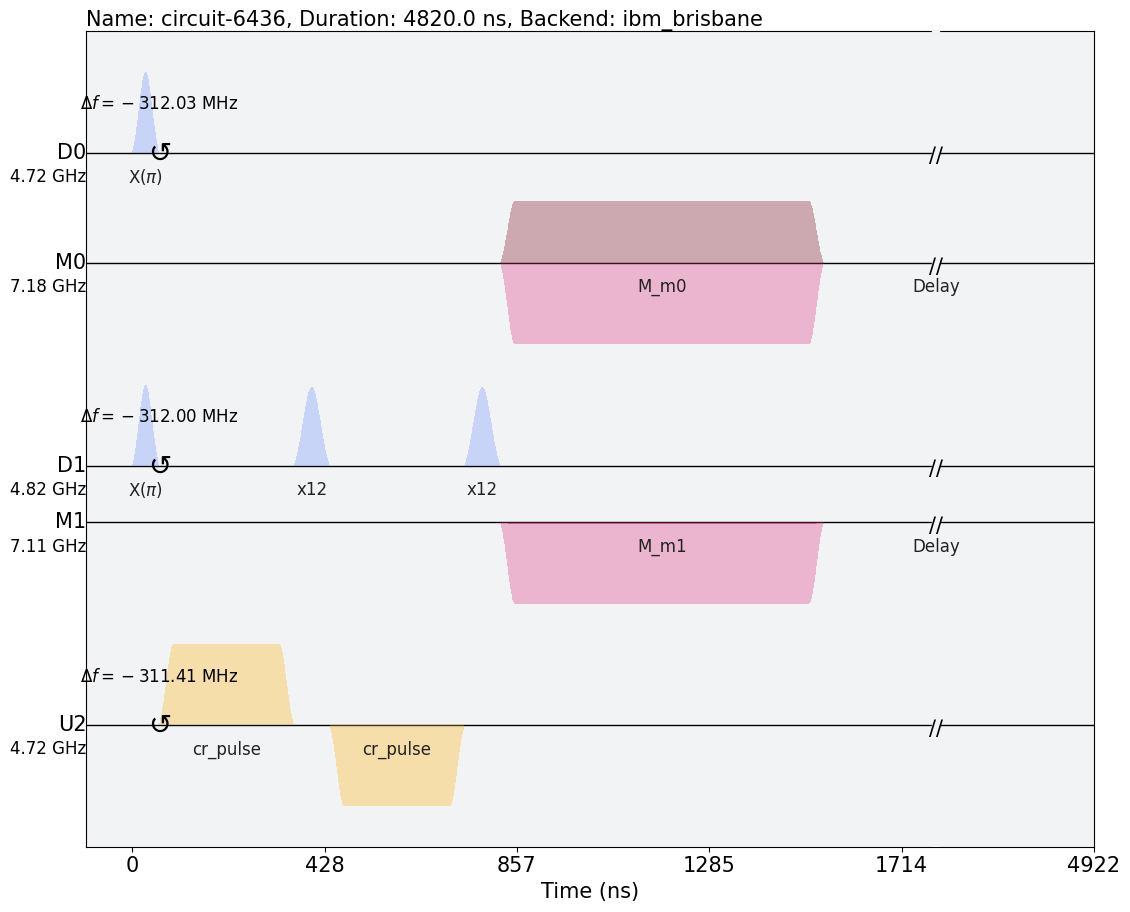

In [ ]:
from qiskit import transpile, schedule
cr_test_scheds = schedule(exp_cr_sweep_circs[25], backend)
cr_test_scheds.draw(backend = backend)

In [ ]:
# cr_freq_sweep_job = backend.run(exp_cr_sweep_circs, meas_level=1, meas_return = 'single', shots = 512)

In [ ]:
print(cr_amp)

0.175


In [ ]:
cr_freq_results = backend.retrieve_job('crt6q857jqmg008zg2s0').result()

4.379881015923387
[14, 446, 52] 0.796875
[10, 465, 37] 0.85546875

4.381105505719306
[18, 442, 52] 0.796875
[11, 453, 48] 0.8125

4.382329995515224
[17, 449, 46] 0.8203125
[7, 456, 49] 0.80859375

4.383554485311143
[12, 441, 59] 0.76953125
[12, 471, 29] 0.88671875

4.384778975107062
[17, 452, 43] 0.83203125
[9, 473, 30] 0.8828125

4.386003464902979
[14, 439, 59] 0.76953125
[7, 467, 38] 0.8515625

4.387227954698897
[13, 444, 55] 0.78515625
[12, 460, 40] 0.84375

4.388452444494816
[11, 440, 61] 0.76171875
[9, 465, 38] 0.8515625

4.389676934290734
[18, 448, 46] 0.8203125
[15, 458, 39] 0.84765625

4.390901424086652
[19, 457, 36] 0.859375
[10, 469, 33] 0.87109375

4.3921259138825715
[13, 449, 50] 0.8046875
[13, 456, 43] 0.83203125

4.39335040367849
[15, 451, 46] 0.8203125
[12, 459, 41] 0.83984375

4.394574893474408
[23, 443, 46] 0.8203125
[13, 456, 43] 0.83203125

4.395799383270327
[14, 460, 38] 0.8515625
[15, 454, 43] 0.83203125

4.397023873066245
[16, 447, 49] 0.80859375
[14, 461, 37] 0.8

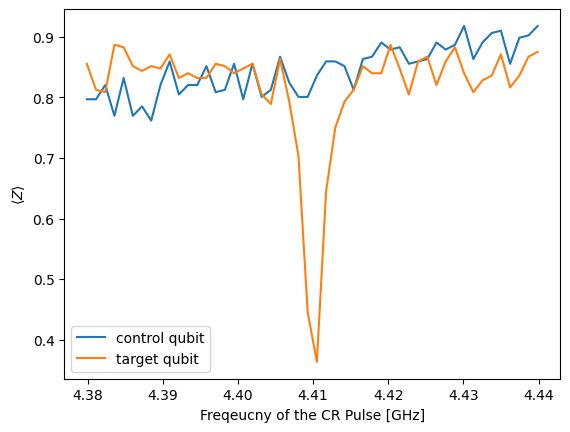

In [ ]:
control_expectations = []
target_expectations = []
classifier1 = qubit_classifiers[1]
classifier2 = qubit_classifiers[0]
for i in range(50):
    iq_data0 = cr_freq_results.get_memory(i)[:, target_qubit] * scale_factor
    # if i <= 31:
    iq_data1 = cr_freq_results.get_memory(i)[:, control_qubit] * scale_factor

    val0 = classifier2.predict(reshape_complex_vec(iq_data0))
    val1 = classifier1.predict(reshape_complex_vec(iq_data1))
    control_expectation = 0
    target_expectation = 0
    target_results = [0,0,0]
    control_results = [0,0,0]
    for v in val0:
        if v == 0:
            target_expectation += 1
            target_results[0]+=1
        if v == 1:
            target_expectation += 1
            target_results[1]+=1
        if v == 2:
            target_expectation -= 1
            target_results[2]+=1
    for v in val1:
        if v == 0:
            control_expectation += 1
            control_results[0]+=1
        if v == 1:
            control_expectation += 1
            control_results[1]+=1
        if v == 2:
            control_expectation -= 1
            control_results[2]+=1
    control_expectations.append(control_expectation/512)
    target_expectations.append(target_expectation/512)
    print(sweep_freqs[i]/GHz)
    print(control_results, control_expectation/512)
    print(target_results, target_expectation/512)
    print()
plt.plot(sweep_freqs/GHz, control_expectations, label = 'control qubit')
plt.plot(sweep_freqs/GHz, target_expectations, label = 'target qubit')
plt.xlabel('Freqeucny of the CR Pulse [GHz]')
plt.ylabel('$\\langle Z\\rangle$')
plt.legend()
plt.show()

CR Gate Tuning

In [17]:
def cr_pulse_sequence(control_in_two:bool, basis, cr_amp:float, cr_duration, cr_square_width, cr_phase, cancel_amp, cancel_phase):
    with pulse.build(backend=backend, name='CR amp sweep') as cr_sched:
        u_chan = pulse.control_channels(control_qubit, target_qubit)[0]
        target_chan = pulse.DriveChannel(target_qubit)
        control_chan = pulse.DriveChannel(control_qubit)
        pulse.set_frequency(control_qbit_x12_freq, control_chan)
        pulse.set_frequency(target_qbit_x12_freq, target_chan)
        pulse.set_frequency(target_qbit_x12_freq, u_chan)
        with pulse.align_sequential():
            if(control_in_two):
                pulse.call(cq_x12_gate)
            with pulse.align_left():
                # pulse.play(pulse.GaussianSquare(duration=cr_duration,
                #                         amp=cancel_amp, angle = cancel_phase,
                #                         sigma=cr_sigma, width = cr_square_width,
                #                         name='cr_pulse'), target_chan)
                
                pulse.play(pulse.GaussianSquare(duration=cr_duration,
                                amp=cr_amp, angle = cr_phase,
                                sigma=cr_sigma, width = cr_square_width,
                                name='cr_pulse'), u_chan)                     
            pulse.call(cq_x12_gate)
            with pulse.align_right():
                # pulse.play(pulse.GaussianSquare(duration=cr_duration,
                #                     amp= - cancel_amp, angle = cancel_phase,
                #                     sigma=cr_sigma, width = cr_square_width,
                #                     name='cr_pulse'), target_chan)

                pulse.play(pulse.GaussianSquare(duration=cr_duration,
                                    amp=-cr_amp, angle = cr_phase,
                                    sigma=cr_sigma, width = cr_square_width,
                                    name='cr_pulse'), u_chan)
            pulse.call(cq_x12_gate)
            if basis == 'X':
                pulse.call(tq_h_gate)
            elif basis == 'Y':
                pulse.shift_phase(3*np.pi/2, target_chan)
                pulse.call(tq_h_gate)
    return cr_sched

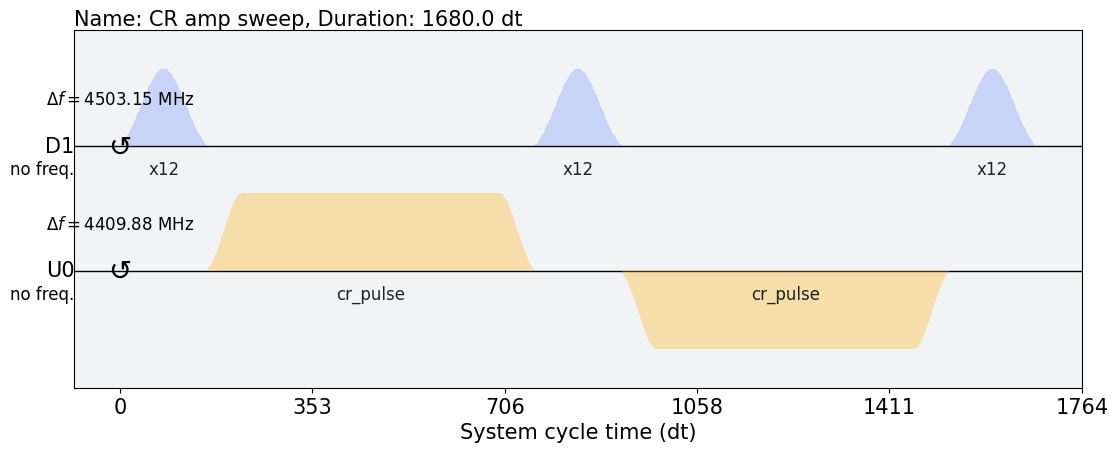

In [18]:
cr_pulse_sequence(True, 'Z', 1, cr_duration, cr_square_width, 0, 0, 0).draw()

In [ ]:
def build_cr_amp_scheds(qc: int, qt: int, cr_amps, phase = 0.0, ZI_MHz = 0.0) -> np.array:
    """Build an array of cross resonance schedules for the Hamiltonian tomography experiment.
    
    Args:
      qc: control qubit index
      qt: target qubit index
      cr_amps: array of widths of the cross resonance pulses
      phase: phase offset of the cross resonance pulse (rad)
      ZI_MHz: ZI interaction rate (in MHz) to correct for with frame change
    """
    tomo_circs = []
    cr_gate = Gate('CR Pulse', 2, [])
    for cr_amp in cr_amps:
        for basis in ['Z']:
            for control in ['1']:
                control_in_two = False
                if control == '2':
                    control_in_two = True
                # framechange = 2 * np.pi * int(cr_square_width) * dt * ZI_MHz * 1e6
                cr_sched = cr_pulse_sequence(control_in_two, basis, cr_amp, cr_duration, cr_square_width,0,0,0)
                tomo_circ = QuantumCircuit(2, 2) 
                tomo_circ.x(0)
                tomo_circ.x(1)
                tomo_circ.append(cr_gate, [qc, qt])  #apply custom cr_gate
                # tomo_circ.rz(-framechange, qc)  #apply frame change on the qc
                # tomo_circ.barrier(qc, qt)
                # for i in [0,1,2,14]:
                tomo_circ.measure(qc, qc)
                tomo_circ.measure(qt, qt)   
                # tomo_circ.measure_all()
                tomo_circ.add_calibration(cr_gate, (qc, qt), cr_sched, [])
                tomo_circs.append(tomo_circ)
                
                
    tomo_circs_transpiled = transpile(tomo_circs, backend, optimization_level = 1)            
    return tomo_circs_transpiled, schedule(tomo_circs_transpiled, backend=backend)

60


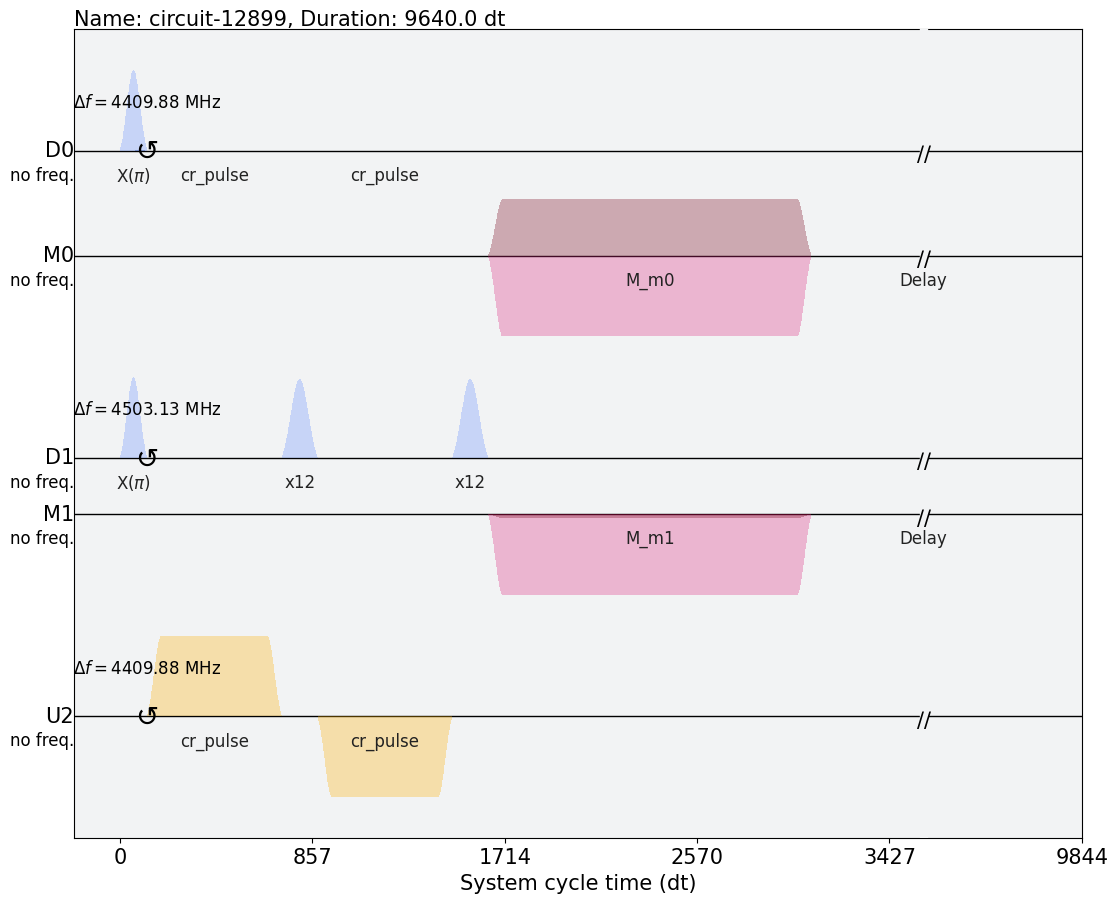

In [ ]:

cr_amps = np.arange(0,0.3,0.005)
exp_cr_amp_circs, cr_scheds = build_cr_amp_scheds(control_qubit, target_qubit, cr_amps)
print(len(exp_cr_amp_circs))
cr_scheds[9].draw()

In [ ]:
# cr_amp_job = backend.run(exp_cr_amp_circs, meas_level=1, meas_return = 'single', shots = 2048)

In [ ]:
cr_amp_results = backend.retrieve_job('crvf55wx484g008f9y6g').result()
# cr_amp_results2 = backend.retrieve_job('crr3k4ckx9hg0081hfzg').result()
# print(cr_amp_results)

0.0 [34, 1460, 554] 0.458984375
0.005 [34, 1709, 305] 0.7021484375
0.01 [33, 1768, 247] 0.7587890625
0.015 [39, 1762, 247] 0.7587890625
0.02 [30, 1778, 240] 0.765625
0.025 [37, 1774, 237] 0.7685546875
0.03 [36, 1779, 233] 0.7724609375
0.035 [40, 1744, 264] 0.7421875
0.04 [43, 1731, 274] 0.732421875
0.045 [47, 1724, 277] 0.7294921875
0.05 [36, 1732, 280] 0.7265625
0.055 [49, 1650, 349] 0.6591796875
0.06 [30, 1695, 323] 0.6845703125
0.065 [56, 1625, 367] 0.6416015625
0.07 [52, 1608, 388] 0.62109375
0.075 [43, 1557, 448] 0.5625
0.08 [34, 1599, 415] 0.5947265625
0.085 [47, 1524, 477] 0.5341796875
0.09 [31, 1528, 489] 0.5224609375
0.095 [39, 1486, 523] 0.4892578125
0.1 [27, 1463, 558] 0.455078125
0.105 [30, 1385, 633] 0.3818359375
0.11 [26, 1421, 601] 0.4130859375
0.115 [34, 1357, 657] 0.3583984375
0.12 [25, 1335, 688] 0.328125
0.125 [32, 1296, 720] 0.296875
0.13 [25, 1299, 724] 0.29296875
0.135 [25, 1277, 746] 0.271484375
0.14 [31, 1265, 752] 0.265625
0.145 [43, 1171, 834] 0.185546875
0.15

Text(0, 0.5, '$\\langle Z\\rangle$ of the Target Qubit')

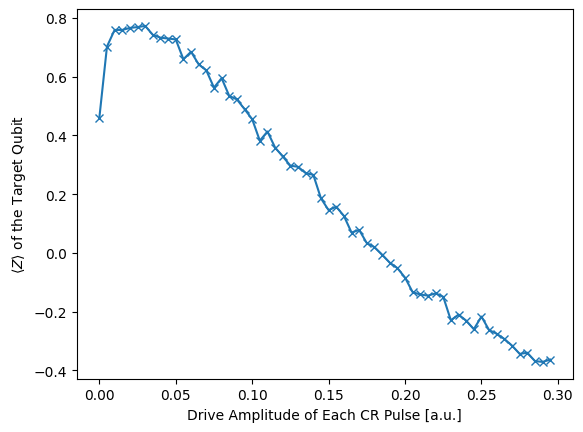

In [ ]:
classifier = qubit_classifiers[target_qubit]
expectation_vals = np.zeros(len(cr_amps))
for i in range(len(exp_cr_amp_circs)):
    iq_data = cr_amp_results.get_memory(i)[:,target_qubit] * scale_factor
    # iq_data2 = cr_amp_results2.get_memory(i)[:,target_qubit] * scale_factor
    val = classifier.predict(reshape_complex_vec(iq_data))
    # val2 = classifier.predict(reshape_complex_vec(iq_data2))

    expectation = 0
    results = [0,0,0]
    for v in val:
        if v == 0:
            expectation += 1
            results[0]+=1
        if v == 1:
            expectation += 1
            results[1]+=1
        if v == 2:
            expectation -= 1
            results[2]+=1
    # for v in val2:
    #     if v == 0:
    #         expectation += 1
    #         results[0]+=1
    #     if v == 1:
    #         expectation += 1
    #         results[1]+=1
    #     if v == 2:
    #         expectation -= 1
    #         results[2]+=1
    # if i % 2 == 0:
    print(cr_amps[i], results, expectation/(2048))
    expectation_vals[i] = expectation/(2048)
plt.plot(cr_amps, expectation_vals, marker = 'x')
plt.xlabel('Drive Amplitude of Each CR Pulse [a.u.]')
plt.ylabel('$\langle Z\\rangle$ of the Target Qubit')
# plt.ylim(0,1)



In [19]:
cr_amp = 0.18 #for two gates it is 0.18, for one gate it is 0.62
print(cr_amp) #induces pi/2 rotation supposedly

0.18


-4.4571383212127 0.1096537668565927


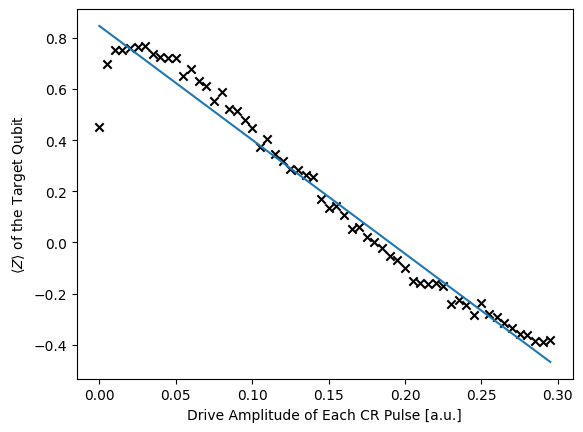

In [ ]:
fit_params, fit, err = fit_function(cr_amps, expectation_vals, lambda x, A, B: A*x + B, [-5.5, 1])
plt.scatter(cr_amps, expectation_vals, marker = 'x', color = 'black')
plt.plot(cr_amps, fit)
plt.xlabel('Drive Amplitude of Each CR Pulse [a.u.]')
plt.ylabel('$\langle Z\\rangle$ of the Target Qubit')
print(fit_params[0], np.sqrt(err[0,0]))

Sanity Check for Amplitudes

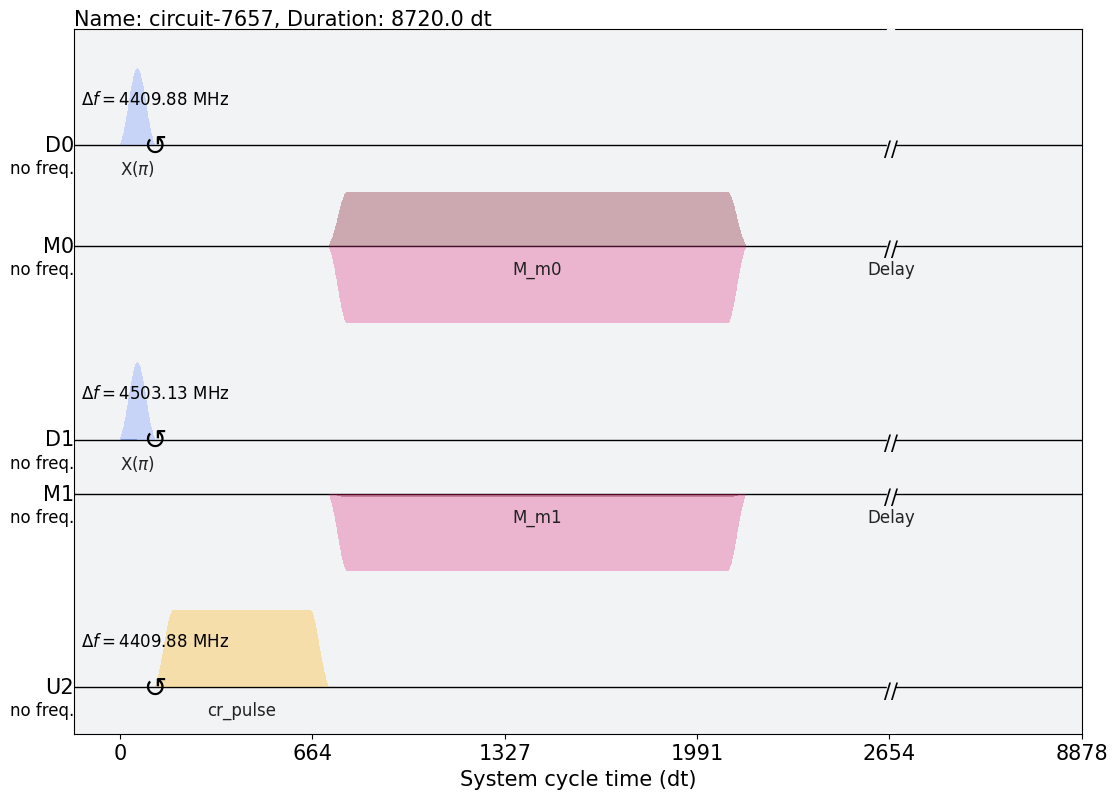

In [ ]:
cr_gate = Gate('CR Pulse', 2, [])
cr_sched1 = cr_pulse_sequence(False, 'Z', cr_amp, cr_duration, cr_square_width, 0.0,0,0)
tomo_circ1 = QuantumCircuit(2, 2) 
tomo_circ1.x(0)
tomo_circ1.x(1)
tomo_circ1.append(cr_gate, [control_qubit, target_qubit])  #apply custom cr_gate
# tomo_circ.rz(-framechange, qc)  #apply frame change on the qc
# tomo_circ.barrier(qc, qt)
# for i in [0,1,2,14]:
tomo_circ1.measure(control_qubit, control_qubit)
tomo_circ1.measure(target_qubit, target_qubit)   
# tomo_circ.measure_all()
tomo_circ1.add_calibration(cr_gate, (control_qubit, target_qubit), cr_sched1, [])
schedule(tomo_circ1, backend).draw()

In [ ]:
# cr_amp_check = backend.run(tomo_circ1, meas_level=1, meas_return = 'single', shots = 2048)

In [ ]:
amp_check_results = backend.retrieve_job('crvc5ky7wv80008fe690').result()

In [ ]:
classifier = qubit_classifiers[target_qubit]
for i in range(1):
    iq_data = amp_check_results.get_memory(i)[:,target_qubit] * scale_factor
    val = classifier.predict(reshape_complex_vec(iq_data))

    expectation = 0
    results = [0,0,0]
    for v in val:
        if v == 0:
            # expectation += 1
            results[0]+=1
        if v == 1:
            expectation += 1
            results[1]+=1
        if v == 2:
            expectation -= 1
            results[2]+=1
    print(results, expectation/(2048-results[0]))

[34, 1016, 998] 0.00893743793445879


In [698]:
IBMQ.save_account('52d6100c45751e631f6d9369baf61398416d72da27c3c36b0f02c7879c7814419e4ae3757f6edd7ebd3c640022d4778f87aa0ec67b03852a40d680f4076136c4', overwrite=True)
IBMQ.load_account()

# get backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_brisbane')
backend_defaults = backend.defaults()

ibmqfactory.load_account:WARNING:2024-05-07 09:48:56,427: Credentials are already in use. The existing account in the session will be replaced.


In [20]:
def build_cr_tomo_scheds(qc: int, qt: int, cr_times, phase, cancellation_amp, cancellation_phase, ZI_MHz = 0.0) -> np.array:
    """Build an array of cross resonance schedules for the Hamiltonian tomography experiment.
    
    Args:
      qc: control qubit index
      qt: target qubit index
      cr_amps: array of widths of the cross resonance pulses
      phase: phase offset of the cross resonance pulse (rad)
      ZI_MHz: ZI interaction rate (in MHz) to correct for with frame change
    """
    tomo_circs = []
    cr_gate = Gate('CR Pulse', 2, [])
    # for cr_phase in cr_phases:
    for width in cr_times:
        cr_duration = int(width + 2 * cr_risefall * cr_sigma)
        # print(cr_duration % 16)
        for basis in ['X','Y','Z']:
            for control in ['1', '2']:
                control_in_two = False
                if control == '2':
                    control_in_two = True
                # framechange = 2 * np.pi * int(cr_square_width) * dt * ZI_MHz * 1e6
                cr_sched = cr_pulse_sequence(control_in_two, basis, cr_amp, cr_duration, width, phase, cancellation_amp, cancellation_phase)
                tomo_circ = QuantumCircuit(2, 2) 
                tomo_circ.x(qc)
                tomo_circ.x(qt)
                tomo_circ.append(cr_gate, [qc, qt])  #apply custom cr_gate
                # tomo_circ.rz(-framechange, qc)  #apply frame change on the qc
                # tomo_circ.barrier(qc, qt)
                # for i in range(127):
                tomo_circ.measure(qc, qc)
                tomo_circ.measure(qt, qt)  
                # tomo_circ.measure_all()
                tomo_circ.add_calibration(cr_gate, (qc, qt), cr_sched, [])
                tomo_circs.append(tomo_circ)
                
                
    # tomo_circs_transpiled = transpile(tomo_circs, backend, optimization_level = 1)            
    return tomo_circs, schedule(tomo_circs, backend=backend)

In [21]:
print(cr_amp)

0.18


[ 128.  224.  320.  416.  512.  608.  704.  800.  896.  992. 1088. 1184.
 1280. 1376. 1472. 1568. 1664. 1760. 1856. 1952. 2048.]
126


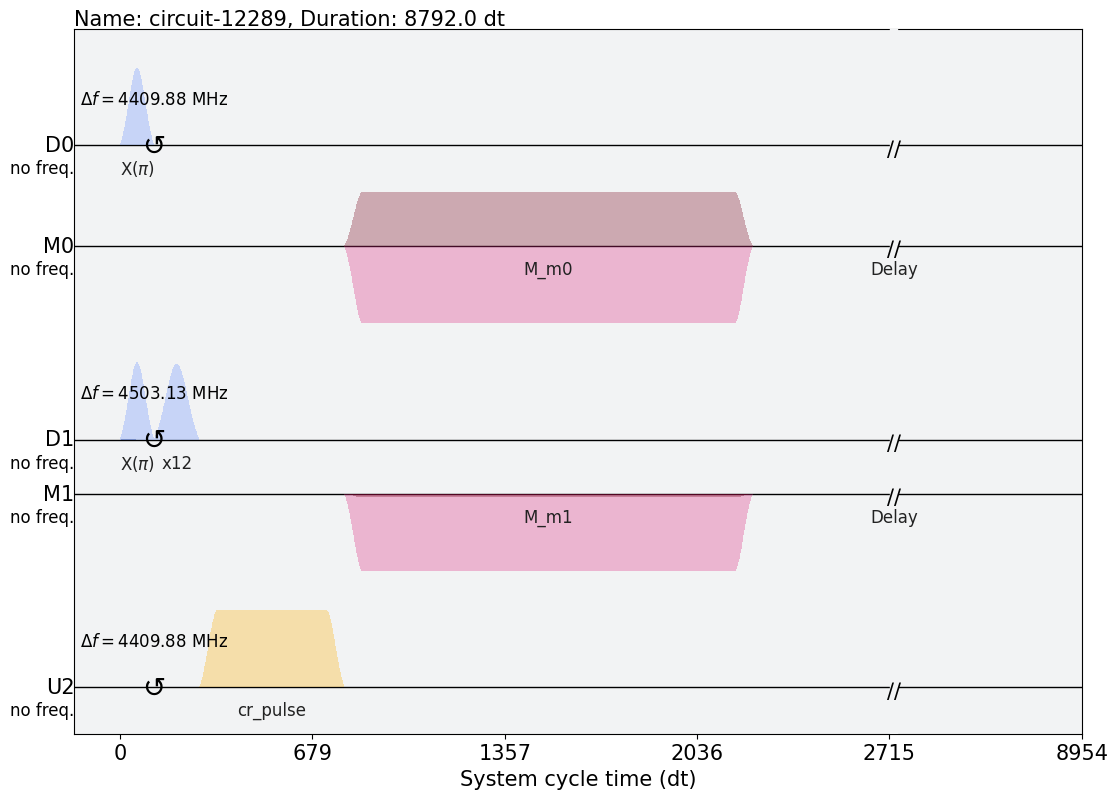

In [ ]:
cr_times = 16*np.linspace(0,120,21)
print(cr_times+cr_risefall*2*cr_sigma)
exp_cr_tomo_circs, cr_scheds = build_cr_tomo_scheds(control_qubit, target_qubit, cr_times, 0,0,0)
print(len(exp_cr_tomo_circs))
cr_scheds[29].draw()

In [ ]:
cr_tomo_job_ids = []

In [ ]:
# cr_tomo_job = backend.run(exp_cr_tomo_circs, meas_level=1, meas_return = 'single', shots = 1536)
# cr_tomo_job_ids.append(cr_tomo_job.job_id())
# job_monitor(cr_tomo_job)

In [663]:
cr_tomo_results = backend.retrieve_job('crsde0gy7jt0008006yg').result()
# cr_tomo_results2 = backend.retrieve_job('crr429h7wv80008f20fg').result()

In [664]:

classifier = qubit_classifiers[target_qubit]
expectation_vals = np.zeros((6, len(cr_times)))
for i in range(6*len(cr_times)):
    iq_data = cr_tomo_results.get_memory(i)[:,target_qubit] * scale_factor
    # iq_data2 = cr_tomo_results2.get_memory(i)[:,target_qubit] * scale_factor
    val = classifier.predict(reshape_complex_vec(iq_data))
    # val2 = classifier.predict(reshape_complex_vec(iq_data2))

    expectation = 0
    results = [0,0,0]
    for v in val:
        if v == 0:
            expectation += 1
            results[0]+=1
        if v == 1:
            expectation -= 1
            results[1]+=1
        if v == 2:
            expectation -= 1
            results[2]+=1
    # for v in val2:
    #     if v == 0:
    #         expectation += 1
    #         results[0]+=1
    #     if v == 1:
    #         expectation += 1
    #         results[1]+=1
    #     if v == 2:
    #         expectation -= 1
    #         results[2]+=1
    # if i % 2 == 0:
    print(i//6, results, expectation/(512))
    expectation_vals[i%6, i//6] = expectation/(512)


0 [247, 239, 26] -0.03515625
0 [242, 252, 18] -0.0546875
0 [206, 285, 21] -0.1953125
0 [312, 193, 7] 0.21875
0 [494, 16, 2] 0.9296875
0 [484, 27, 1] 0.890625
1 [264, 225, 23] 0.03125
1 [246, 251, 15] -0.0390625
1 [88, 395, 29] -0.65625
1 [415, 89, 8] 0.62109375
1 [433, 71, 8] 0.69140625
1 [427, 81, 4] 0.66796875
2 [267, 229, 16] 0.04296875
2 [256, 237, 19] 0.0
2 [21, 458, 33] -0.91796875
2 [470, 39, 3] 0.8359375
2 [301, 196, 15] 0.17578125
2 [294, 194, 24] 0.1484375
3 [251, 235, 26] -0.01953125
3 [255, 241, 16] -0.00390625
3 [40, 432, 40] -0.84375
3 [444, 57, 11] 0.734375
3 [165, 319, 28] -0.35546875
3 [129, 360, 23] -0.49609375
4 [254, 242, 16] -0.0078125
4 [271, 228, 13] 0.05859375
4 [135, 344, 33] -0.47265625
4 [344, 157, 11] 0.34375
4 [47, 435, 30] -0.81640625
4 [41, 439, 32] -0.83984375
5 [232, 260, 20] -0.09375
5 [244, 252, 16] -0.046875
5 [250, 238, 24] -0.0234375
5 [219, 276, 17] -0.14453125
5 [10, 465, 37] -0.9609375
5 [24, 449, 39] -0.90625
6 [261, 229, 22] 0.01953125
6 [246,

In [703]:
avg_t_c = expectation_vals

In [704]:
from scipy.optimize import curve_fit

def get_omega(eDelta, eOmega_x, eOmega_y):
    """Return \Omega from parameter arguments."""
    eOmega = np.sqrt(eDelta**2 + eOmega_x**2 + eOmega_y**2)
    return eOmega

def avg_X(t, eDelta, eOmega_x, eOmega_y, T, T2, T3):
    """Return average X Pauli measurement vs time t"""
    eOmega = get_omega(eDelta, eOmega_x, eOmega_y)
    eXt = (-eDelta*eOmega_x + np.exp(-t/T)*(eDelta*eOmega_x*np.cos(eOmega*t) + \
           eOmega*eOmega_y*np.sin(eOmega*t))) / eOmega**2 
    return eXt

def avg_Y(t, eDelta, eOmega_x, eOmega_y, T, T2, T3):
    """Return average Y Pauli measurement vs time t"""
    eOmega = get_omega(eDelta, eOmega_x, eOmega_y)
    eYt = (eDelta*eOmega_y - np.exp(-t/T2)*(eDelta*eOmega_y*np.cos(eOmega*t) - \
           eOmega*eOmega_x*np.sin(eOmega*t))) / eOmega**2 
    return eYt

def avg_Z(t, eDelta, eOmega_x, eOmega_y, T, T2, T3):
    """Return average Z Pauli measurement vs time t"""
    eOmega = get_omega(eDelta, eOmega_x, eOmega_y)
    eZt = (eDelta**2 + np.exp(-t/T3)*(eOmega_x**2 + eOmega_y**2)*np.cos(eOmega*t)) / eOmega**2 
    return eZt

def rt_evol(ts, eDelta, eOmega_x, eOmega_y, T, T2, T3):
    """Stack average X,Y,Z Pauli measurements vertically."""
    return np.vstack([avg_X(ts, eDelta, eOmega_x, eOmega_y,T, T2, T3), \
                     avg_Y(ts, eDelta, eOmega_x, eOmega_y,T, T2, T3), \
                     avg_Z(ts, eDelta, eOmega_x, eOmega_y,T, T2, T3)])
    
def rt_flat(ts, eDelta, eOmega_x, eOmega_y, T, T2, T3):
    """Flatten X,Y,Z Pauli measurement data into 1D array."""
    return rt_evol(ts[0:len(ts)//3], eDelta, eOmega_x, eOmega_y, T, T2, T3).flatten()

def fit_rt_evol(ts, eXt, eYt, eZt, p0):
    """Use curve_fit to determine fit parameters of X,Y,Z Pauli measurements together."""
    rt_vec = np.asarray([eXt, eYt, eZt])
    
    return curve_fit(rt_flat, np.tile(ts, 3), rt_vec.flatten(), p0=p0, method='trf')

In [705]:
def get_omega_exc(eDelta, eOmega_x, eOmega_y):
    """Return \Omega from parameter arguments."""
    eOmega = np.sqrt(eDelta**2 + eOmega_x**2 + eOmega_y**2)
    return eOmega

def avg_X_exc(t, eDelta, eOmega_x, eOmega_y, T, T2, T3):
    """Return average X Pauli measurement vs time t"""
    eOmega = get_omega_exc(eDelta, eOmega_x, eOmega_y)
    eXt = (-eDelta*eOmega_x + np.exp(-t/T)*(eDelta*eOmega_x*np.cos(eOmega*t) + \
           eOmega*eOmega_y*np.sin(eOmega*t)))/ eOmega**2
    return eXt

def avg_Y_exc(t, eDelta, eOmega_x, eOmega_y, T,T2,T3):
    """Return average Y Pauli measurement vs time t"""
    eOmega = get_omega_exc(eDelta, eOmega_x, eOmega_y)
    eYt = (eDelta*eOmega_y - np.exp(-t/T2)*(eDelta*eOmega_y*np.cos(eOmega*t) - \
           eOmega*eOmega_x*np.sin(eOmega*t))) / eOmega**2 
    return eYt

def avg_Z_exc(t, eDelta, eOmega_x, eOmega_y, T,T2,T3):
    """Return average Z Pauli measurement vs time t"""
    eOmega = get_omega_exc(eDelta, eOmega_x, eOmega_y)
    eZt = (eDelta**2 + np.exp(-t/T3)*(eOmega_x**2 + eOmega_y**2)*np.cos(eOmega*t)) / eOmega**2 
    return eZt

def rt_evol_exc(ts, eDelta, eOmega_x, eOmega_y, T,T2,T3):
    """Stack average X,Y,Z Pauli measurements vertically."""
    return np.vstack([avg_X_exc(ts, eDelta, eOmega_x, eOmega_y,T ,T2,T3), \
                     avg_Y_exc(ts, eDelta, eOmega_x, eOmega_y, T, T2, T3), \
                     avg_Z_exc(ts, eDelta, eOmega_x, eOmega_y, T, T2, T3)])
    
def rt_flat_exc(ts, eDelta, eOmega_x, eOmega_y, T,T2,T3):
    """Flatten X,Y,Z Pauli measurement data into 1D array."""
    return rt_evol_exc(ts[0:len(ts)//3], eDelta, eOmega_x, eOmega_y, T, T2, T3).flatten()

def fit_rt_evol_exc(ts, eXt, eYt, eZt, p0):
    """Use curve_fit to determine fit parameters of X,Y,Z Pauli measurements together."""
    rt_vec = np.asarray([eXt, eYt, eZt])
    
    return curve_fit(rt_flat_exc, np.tile(ts, 3), rt_vec.flatten(), p0=p0, method='trf')

In [706]:
def get_interation_rates_MHz(ground_fit, excited_fit):
    """Determine interaction rates from fits to ground and excited control qubit data."""
    Delta0 = (ground_fit[0]/dt)/1e6
    Omega0_x = (ground_fit[1]/dt)/1e6
    Omega0_y = (ground_fit[2]/dt)/1e6
    Delta1 = (excited_fit[0]/dt)/1e6
    Omega1_x = (excited_fit[1]/dt)/1e6
    Omega1_y = (excited_fit[2]/dt)/1e6
    
    IX = 0.5*(Omega0_x + Omega1_x)

    IY = 0.5*(Omega0_y + Omega1_y)
    IZ = 0.5*(Delta0 + Delta1)
    ZX = 0.5*(Omega0_x - Omega1_x)
    ZY = 0.5*(Omega0_y - Omega1_y)
    ZZ = 0.5*(Delta0 - Delta1)
    
    return [[IX, IY, IZ], [ZX, ZY, ZZ]]

def plot_cr_ham_tomo(cr_times, avg_t_c, ground_fit, excited_fit):
    """Plot Hamiltonian tomography data and curve fits with interaction rates."""
    coeffs = get_interation_rates_MHz(ground_fit, excited_fit)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15), sharey = True)
    ax1.scatter(cr_times, avg_t_c[0,:].real, lw=3.0, color='blue', label='ctrl in |1>')
    ax1.plot(cr_times, avg_X(cr_times, *ground_fit), lw=3.0, color='blue')
    ax1.scatter(cr_times, avg_t_c[1,:].real, lw=3.0, color='red', label='ctrl in |2>')
    ax1.plot(cr_times, avg_X(cr_times, *excited_fit), lw=3.0, color='red')
    ax1.set_ylabel('<X(t)>', fontsize=20)
    ax1.set_title('Pauli Expectation Value', fontsize=20)
    ax1.legend(loc=4, fontsize=14)
    ax2.scatter(cr_times, avg_t_c[2,:].real, lw=3.0, color='blue', label='ctrl in |1>')
    ax2.plot(cr_times, avg_Y(cr_times, *ground_fit), lw=3.0, color='blue')
    ax2.scatter(cr_times, avg_t_c[3,:].real, lw=3.0, color='red', label='ctrl in |2>')
    ax2.plot(cr_times, avg_Y(cr_times, *excited_fit), lw=3.0, color='red')
    ax2.set_title('IX = %.3f MHz   IY = %.3f MHz   IZ = %.3f MHz' % \
              (coeffs[0][0], coeffs[0][1], coeffs[0][2]), fontsize=20)
    ax2.set_ylabel('<Y(t)>', fontsize=20)
    ax2.legend(loc=4, fontsize=14)
    ax3.scatter(cr_times, avg_t_c[4,:].real, lw=3.0, color='blue', label='ctrl in |1>')
    ax3.plot(cr_times, avg_Z(cr_times, *ground_fit), lw=3.0, color='blue')
    ax3.scatter(cr_times, avg_t_c[5,:].real, lw=3.0, color='red', label='ctrl in |2>')
    ax3.plot(cr_times, avg_Z(cr_times, *excited_fit), lw=3.0, color='red')
    ax3.set_title('ZX = %.3f MHz   ZY = %.3f MHz   ZZ = %.3f MHz' % \
              (coeffs[1][0], coeffs[1][1], coeffs[1][2]), fontsize=20)
    ax3.set_ylabel('<Z(t)>', fontsize=20)
    ax3.set_xlabel('time (dt)', fontsize=20)
    ax3.legend(loc=4, fontsize=14)

[-8.42747852e-05  2.24505892e-03 -3.87549527e-04  1.24406326e+09
  2.86826840e+02  2.23163473e+02]
0.16729962538442225 0.34799703759484973 0.27665166073854225
[-3.23075240e-04 -2.79233629e-03  6.35891515e-04  6.26113899e+09
  3.05392646e+02  5.78300400e+02]
0.17246840503492628 0.21620019852768152 0.31273829714443585
0.2820986180612656
0.06589841953358411
0.29469497894148905
-0.0180433182029468
0.16988401520967428
-0.002584389825252012


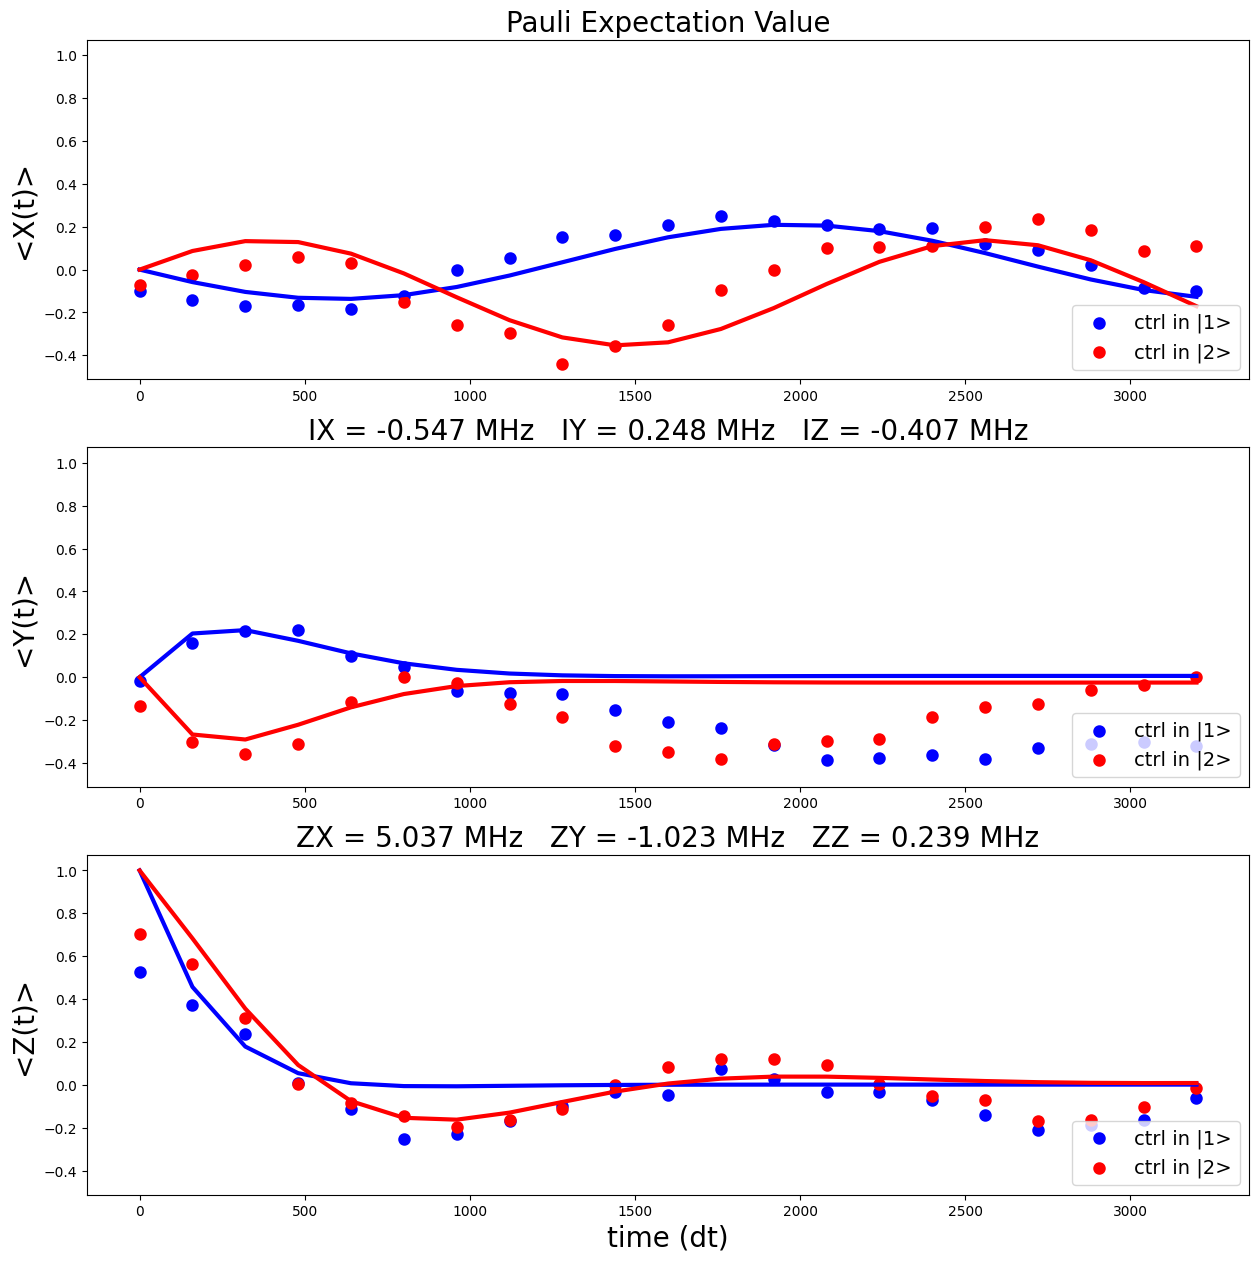

In [719]:
ground_fit,ground_err = fit_rt_evol(cr_times, avg_t_c[0,:], avg_t_c[2,:], avg_t_c[4,:], p0=[-0.0005, 0.001, -0.001, 5000, 5000, 5000])
excited_fit,excited_err = fit_rt_evol_exc(cr_times, avg_t_c[1,:], avg_t_c[3,:], avg_t_c[5,:], p0=[-0.0005, -0.003, 0.003, 5000, 3000, 5000])


print(ground_fit)
print((np.sqrt(ground_err[0,0])/dt)/1e6, (np.sqrt(ground_err[1,1])/dt)/1e6,(np.sqrt(ground_err[2,2])/dt)/1e6)
print(excited_fit)
print(np.sqrt(excited_err[0,0])/dt/1e6,np.sqrt(excited_err[1,1])/dt/1e6,np.sqrt(excited_err[2,2])/dt/1e6)
print(0.5*((np.sqrt(ground_err[1,1])/dt)/1e6 + np.sqrt(excited_err[1,1])/dt/1e6))
print(0.5*((np.sqrt(ground_err[1,1])/dt)/1e6 - np.sqrt(excited_err[1,1])/dt/1e6))
print(0.5*((np.sqrt(ground_err[2,2])/dt)/1e6 + np.sqrt(excited_err[2,2])/dt/1e6))
print(0.5*((np.sqrt(ground_err[2,2])/dt)/1e6 - np.sqrt(excited_err[2,2])/dt/1e6))
print(0.5*((np.sqrt(ground_err[0,0])/dt)/1e6 + np.sqrt(excited_err[0,0])/dt/1e6))
print(0.5*((np.sqrt(ground_err[0,0])/dt)/1e6 - np.sqrt(excited_err[0,0])/dt/1e6))
plot_cr_ham_tomo(cr_times, avg_t_c, ground_fit, excited_fit)

In [384]:
def build_cr_phase_scheds(qc: int, qt: int, cr_phases, ZI_MHz = 0.0) -> np.array:
    """Build an array of cross resonance schedules for the Hamiltonian tomography experiment.
    
    Args:
      qc: control qubit index
      qt: target qubit index
      cr_amps: array of widths of the cross resonance pulses
      phase: phase offset of the cross resonance pulse (rad)
      ZI_MHz: ZI interaction rate (in MHz) to correct for with frame change
    """
    tomo_circs = []
    cr_gate = Gate('CR Pulse', 2, [])
    for phase in cr_phases:
        for basis in ['Y']:
            for control in ['1', '2']:
                control_in_two = False
                if control == '2':
                    control_in_two = True
                # framechange = 2 * np.pi * int(cr_square_width) * dt * ZI_MHz * 1e6
                cr_sched = cr_pulse_sequence(control_in_two, basis, cr_amp, cr_duration, cr_square_width, phase,0,0)
                tomo_circ = QuantumCircuit(backend_config.num_qubits, backend_config.num_qubits) 
                tomo_circ.x(qc)
                tomo_circ.x(qt)
                tomo_circ.append(cr_gate, [qc, qt])  #apply custom cr_gate
                # tomo_circ.rz(-framechange, qc)  #apply frame change on the qc
                # tomo_circ.barrier(qc, qt)
                # for i in range(127):
                tomo_circ.measure(qc, qc)
                tomo_circ.measure(qt, qt)  
                # tomo_circ.measure_all()
                tomo_circ.add_calibration(cr_gate, (qc, qt), cr_sched, [])
                tomo_circs.append(tomo_circ)
                
                
    # tomo_circs_transpiled = transpile(tomo_circs, backend, optimization_level = 1)            
    return tomo_circs, schedule(tomo_circs, backend=backend)

50


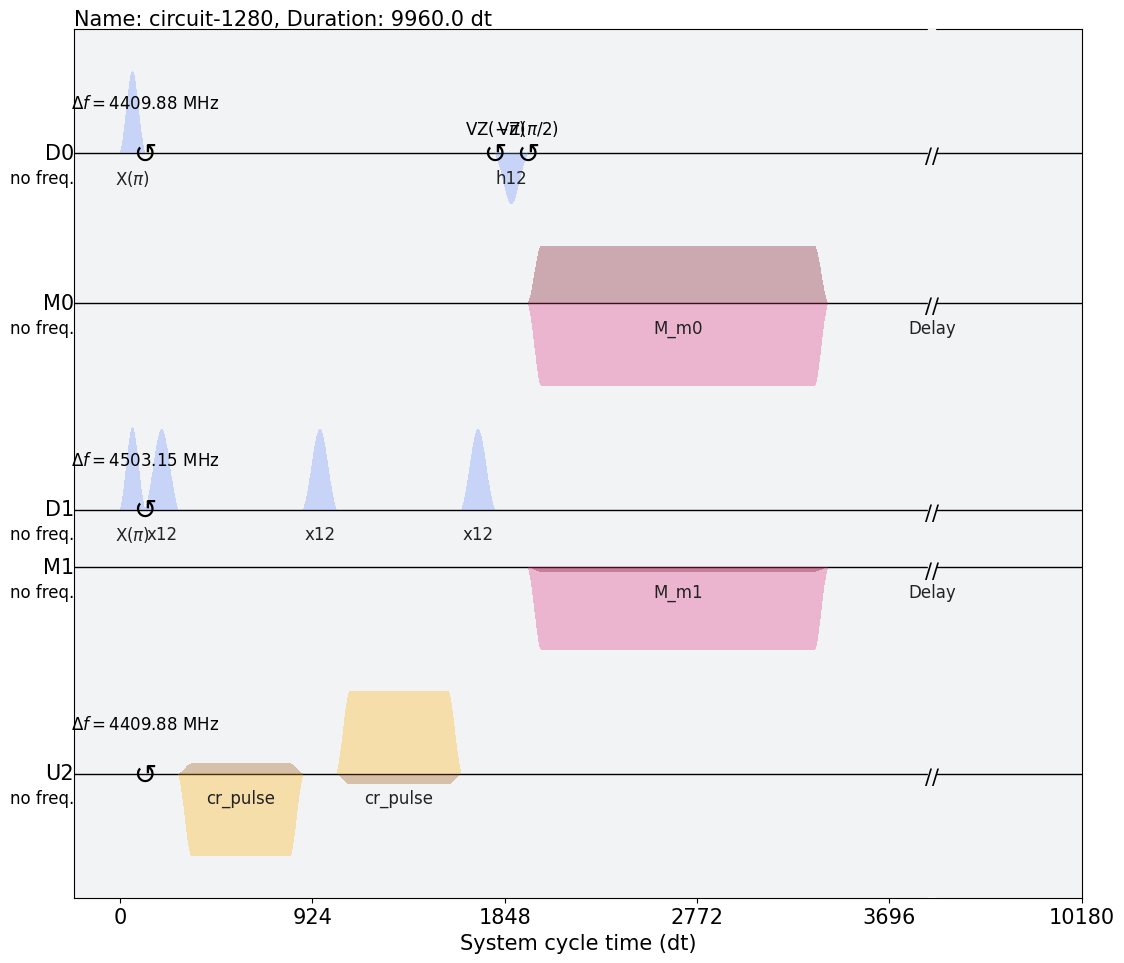

In [104]:
cr_phases = np.arange(0,np.pi,np.pi/25)

exp_cr_phase_circs, cr_scheds = build_cr_phase_scheds(control_qubit, target_qubit, cr_phases)
print(len(exp_cr_phase_circs))
cr_scheds[-1].draw()

In [106]:
# cr_phase_job = backend.run(exp_cr_phase_circs, meas_level=1, meas_return = 'single', shots = 1024)

In [299]:
coeffs = get_interation_rates_MHz(ground_fit, excited_fit)
ZX_rate = coeffs[1][0]
ZY_rate = coeffs[1][1]
IX_rate = coeffs[0][0]
IY_rate = coeffs[0][1]
cr_phase = -np.arctan2(ZY_rate, ZX_rate)
cancellation_phase = -np.arctan2(IY_rate, IX_rate)
print(ZY_rate, ZX_rate, cr_phase)
print(IY_rate, IX_rate, cr_phase - cancellation_phase)

-1.9248306470251413 -2.231588430378039 2.4298643072122417
-1.4365761273968356 -0.8059637073995964 0.3477951554254055


In [696]:
#0.9217258122678619: old cr_phase
# 3.7375591157055594: old cancellation phase
# cr_phase = 1.4255379809051485-2.4415861080847785

Cancellation Tones Calibration

In [303]:
cr_phase = 1.4326480410178366+1.7978318553902481+2.4298643072122417
cancellation_phase = cr_phase - (-0.23715099100948356-0.1912601437369068 + 0.3477951554254055)

In [304]:
print(cr_amp, cr_phase, cancellation_phase)

0.18 5.660344203620326 5.740960182941311


[ 128.  288.  448.  608.  768.  928. 1088. 1248. 1408. 1568. 1728. 1888.
 2048. 2208. 2368. 2528. 2688. 2848. 3008. 3168. 3328.]


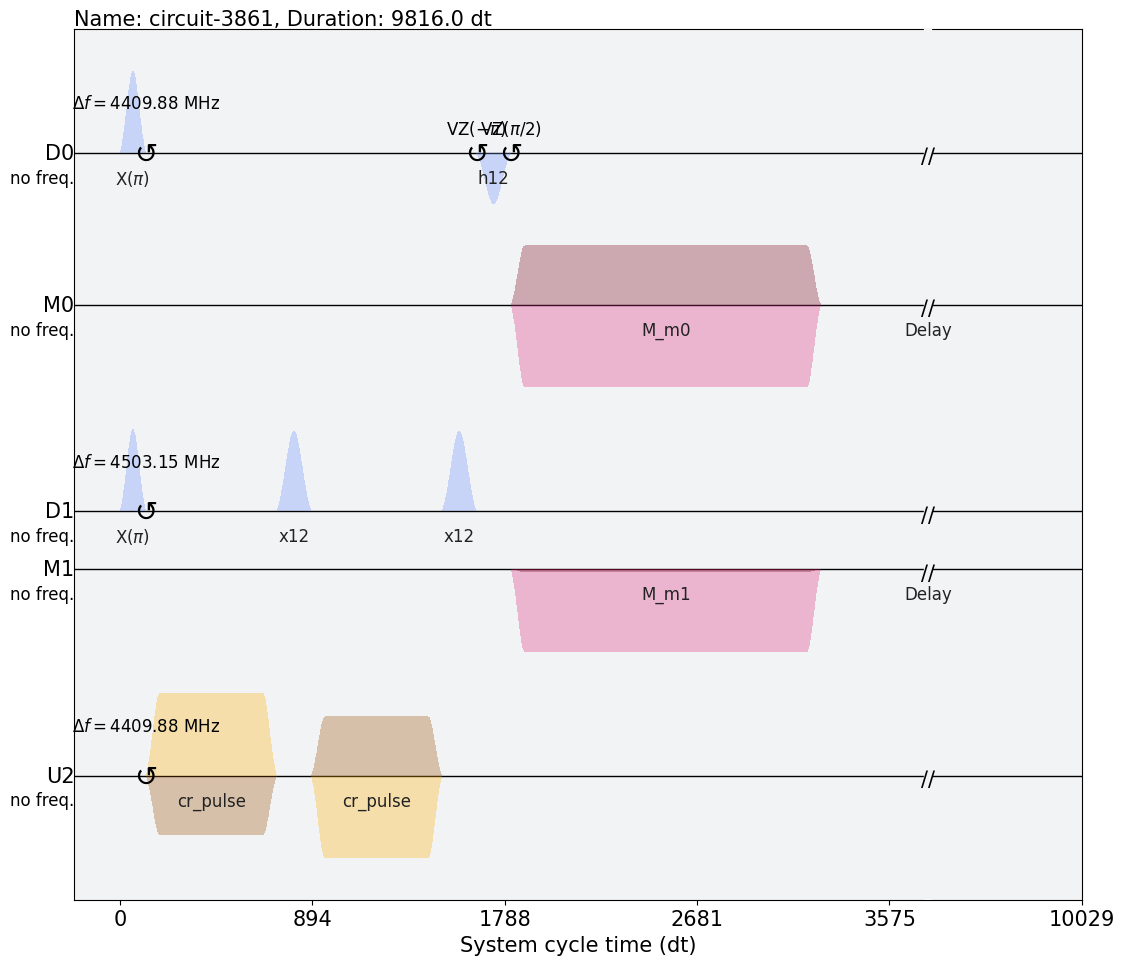

In [700]:
cr_times = 16*np.linspace(0,200,21)
print(cr_times+cr_risefall*2*cr_sigma)
exp_cr_tomo_circs1, cr_scheds = build_cr_tomo_scheds(control_qubit, target_qubit, cr_times, cr_phase,0,0)

cr_scheds[20].draw()

126


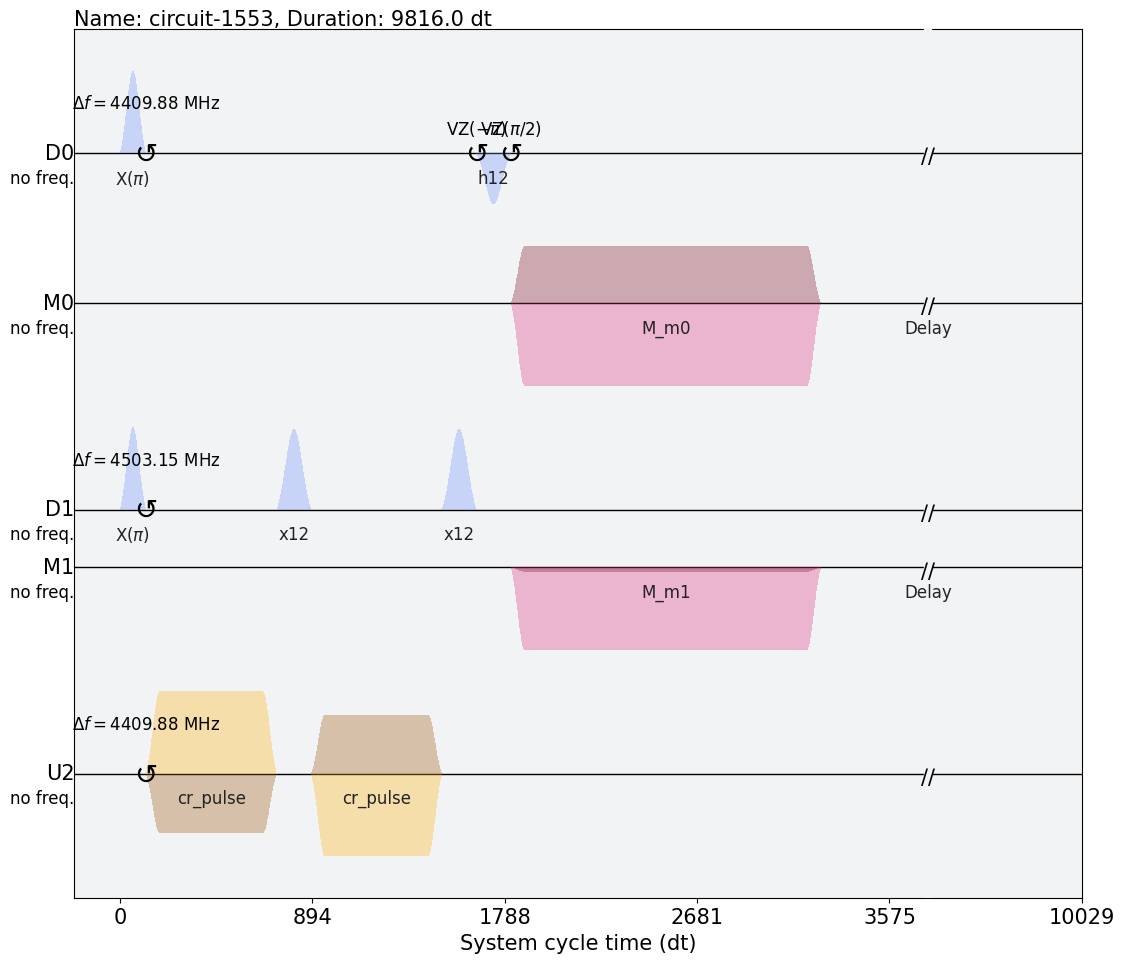

In [305]:
exp_cr_tomo_circs2, cr_scheds = build_cr_tomo_scheds(control_qubit, target_qubit, cr_times, cr_phase, 0.1, cr_phase - cancellation_phase)
print(len(exp_cr_tomo_circs2))
cr_scheds[20].draw()

In [307]:
# cancellation_job = backend.run(exp_cr_tomo_circs1, meas_level=1, meas_return = 'single', shots = 1536)
# cancellation_job2 = backend.run(exp_cr_tomo_circs2, meas_level=1, meas_return = 'single', shots = 1024)

In [699]:
cr_tomo_results = backend.retrieve_job('crwfm18x484g008fctxg').result()

In [26]:
print(cr_times + 2*cr_risefall*cr_sigma)

[ 128.  208.  288.  368.  448.  528.  608.  688.  768.  848.  928. 1008.
 1088. 1168. 1248. 1328. 1408. 1488. 1568. 1648. 1728.]


In [702]:
# avg_t_c = np.zeros((6,len(cr_times)), dtype = complex)
cr_amp_data = []
# iq_data = cr_amp_results.get_memory(0)[:,2] * scale_factor
# print(iq_data)
classifier = qubit_classifiers[0]
expectation_vals = np.zeros((6, len(cr_times)))
for i in range(126):
    iq_data = cr_tomo_results.get_memory(i)[:, 0] * scale_factor
    # iq_data2 = cr_tomo_results2.get_memory(i)[:,target_qubit] * scale_factor
    val = classifier.predict(reshape_complex_vec(iq_data))
    # val2 = classifier.predict(reshape_complex_vec(iq_data2))

    expectation = 0
    results = [0,0,0]
    for v in val:
        if v == 0:
            expectation += 1
            results[0]+=1
        if v == 1:
            expectation += 1
            results[1]+=1
        if v == 2:
            expectation -= 1
            results[2]+=1
    # for v in val2:
    #     if v == 0:
    #         expectation += 1
    #         results[0]+=1
    #     if v == 1:
    #         expectation += 1
    #         results[1]+=1
    #     if v == 2:
    #         expectation -= 1
    #         results[2]+=1
    # if i % 2 == 0:
    print(i//6, results, expectation/(1536))
    expectation_vals[i%6, i//6] = expectation/(1536)
    # avg_t_c[i%6, i//6] = 1-sum(val)/1024

0 [16, 676, 844] -0.09895833333333333
0 [19, 694, 823] -0.07161458333333333
0 [18, 735, 783] -0.01953125
0 [23, 641, 872] -0.13541666666666666
0 [33, 1140, 363] 0.52734375
0 [24, 1284, 228] 0.703125
1 [20, 639, 877] -0.14192708333333334
1 [25, 722, 789] -0.02734375
1 [16, 875, 645] 0.16015625
1 [23, 514, 999] -0.30078125
1 [17, 1037, 482] 0.3723958333333333
1 [19, 1183, 334] 0.5651041666666666
2 [15, 622, 899] -0.17057291666666666
2 [24, 760, 752] 0.020833333333333332
2 [29, 905, 602] 0.21614583333333334
2 [18, 476, 1042] -0.3567708333333333
2 [30, 920, 586] 0.23697916666666666
2 [33, 975, 528] 0.3125
3 [18, 622, 896] -0.16666666666666666
3 [20, 794, 722] 0.059895833333333336
3 [27, 910, 599] 0.22005208333333334
3 [24, 504, 1008] -0.3125
3 [21, 753, 762] 0.0078125
3 [29, 742, 765] 0.00390625
4 [23, 603, 910] -0.18489583333333334
4 [30, 763, 743] 0.032552083333333336
4 [21, 824, 691] 0.10026041666666667
4 [25, 655, 856] -0.11458333333333333
4 [16, 667, 853] -0.11067708333333333
4 [28, 6

In [1002]:
coeffs = get_interation_rates_MHz(ground_fit, excited_fit)
c_IX_1 = coeffs[0][0]
c_IY_1 = coeffs[0][1]
print(c_IX_1, c_IY_1)

0.013464235286079013 -0.2928651540383521


Everything Sucks so we're gonna optimize everything at once :D

In [155]:
cr_phase_results1 = backend.retrieve_job('crwcena7jqmg008zpdz0').result()

0.0 [83, 676, 265] 0.482421875
0.0 [63, 150, 811] -0.583984375
0.12566370614359174 [72, 684, 268] 0.4765625
0.12566370614359174 [66, 147, 811] -0.583984375
0.25132741228718347 [69, 698, 257] 0.498046875
0.25132741228718347 [82, 134, 808] -0.578125
0.3769911184307752 [64, 675, 285] 0.443359375
0.3769911184307752 [61, 151, 812] -0.5859375
0.5026548245743669 [75, 679, 270] 0.47265625
0.5026548245743669 [58, 181, 785] -0.533203125
0.6283185307179586 [79, 680, 265] 0.482421875
0.6283185307179586 [58, 158, 808] -0.578125
0.7539822368615504 [64, 680, 280] 0.453125
0.7539822368615504 [63, 170, 791] -0.544921875
0.8796459430051422 [65, 697, 262] 0.48828125
0.8796459430051422 [66, 130, 828] -0.6171875
1.0053096491487339 [79, 660, 285] 0.443359375
1.0053096491487339 [68, 187, 769] -0.501953125
1.1309733552923256 [73, 673, 278] 0.45703125
1.1309733552923256 [79, 159, 786] -0.53515625
1.2566370614359172 [64, 680, 280] 0.453125
1.2566370614359172 [70, 160, 794] -0.55078125
1.3823007675795091 [71, 68

/opt/homebrew/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


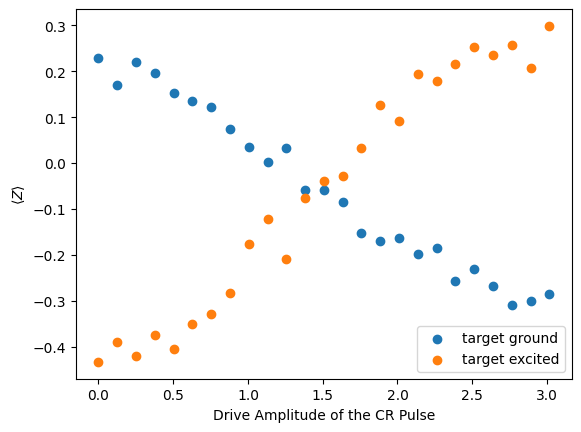

In [157]:
#First we do amplitude 
classifier = qubit_classifiers[control_qubit]
classifier2 = qubit_classifiers[target_qubit]
control_expectation_vals = np.zeros((2,len(cr_phases)), dtype = complex)
target_expectation_vals = np.zeros((2, len(cr_phases)), dtype = complex)
for i in range(len(exp_cr_phase_circs)):
    iq_data0 = cr_phase_results1.get_memory(i)[:, control_qubit] * scale_factor
    # if i <= 31:
    # iq_data1 = cr_amp_results2.get_memory(i)[:, control_qubit] * scale_factor

    val0 = classifier.predict(reshape_complex_vec(iq_data0))
    # val1 = classifier.predict(reshape_complex_vec(iq_data1))
    expectation = 0
    results = [0,0,0]
    for v in val0:
        if v == 0:
            expectation += 1
            results[0]+=1
        if v == 1:
            expectation += 1
            results[1]+=1
        if v == 2:
            expectation -= 1
            results[2]+=1
    # for v in val1:
    #     if v == 0:
    #         expectation += 1
    #         results[0]+=1
    #     if v == 1:
    #         expectation += 1
    #         results[1]+=1
    #     if v == 2:
    #         expectation -= 1
    #         results[2]+=1
    # if i % 2 == 0:
    print(cr_phases[i//2], results, expectation/(1024))
    control_expectation_vals[i%2, i//2] = expectation/(1024)

for i in range(len(exp_cr_phase_circs)):
    iq_data0 = cr_phase_results1.get_memory(i)[:, target_qubit] * scale_factor
    # if i <= 31:
    # iq_data1 = cr_amp_results2.get_memory(i)[:, target_qubit] * scale_factor

    val0 = classifier2.predict(reshape_complex_vec(iq_data0))
    # val1 = classifier2.predict(reshape_complex_vec(iq_data1))
    expectation = 0
    results = [0,0,0]
    for v in val0:
        if v == 0:
            expectation += 1
            results[0]+=1
        if v == 1:
            expectation += 1
            results[1]+=1
        if v == 2:
            expectation -= 1
            results[2]+=1
    # for v in val1:
    #     if v == 0:
    #         # expectation += 1
    #         results[0]+=1
    #     if v == 1:
    #         expectation += 1
    #         results[1]+=1
    #     if v == 2:
    #         expectation -= 1
    #         results[2]+=1
    # if i % 2 == 0:
    print(cr_phases[i//2], results, expectation/(1024))
    target_expectation_vals[i%2, i//2] = expectation/(1024)

# plt.scatter(cr_phases, control_expectation_vals[0,:], label = 'control ground')
plt.scatter(cr_phases, target_expectation_vals[0,:], label = 'target ground')
# plt.scatter(cr_phases, control_expectation_vals[1,:], label = 'control excited')
plt.scatter(cr_phases, target_expectation_vals[1,:], label = 'target excited')
plt.xlabel('Drive Amplitude of the CR Pulse')
plt.ylabel('$\\langle Z\\rangle$')
plt.legend()
plt.show()


Quantum State Tomography

In [456]:
def qpt_cr_pulse_sequence(control_basis, target_basis, cr_amp:float, cr_duration, cr_square_width, cr_phase, target_state_type, control_state_type):
    with pulse.build(backend=backend, name='CR amp sweep') as cr_sched:
        u_chan = pulse.control_channels(control_qubit, target_qubit)[0]
        target_chan = pulse.DriveChannel(target_qubit)
        control_chan = pulse.DriveChannel(control_qubit)
        pulse.set_frequency(control_qbit_x12_freq, control_chan)
        pulse.set_frequency(target_qbit_x12_freq, target_chan)
        pulse.set_frequency(target_qbit_x12_freq, u_chan)
        with pulse.align_sequential():
            with pulse.align_left():
                if target_state_type == 1:
                    pulse.call(tq_x12_gate)
                if target_state_type == 2:
                    pulse.call(tq_h_gate)
                if target_state_type == 3:
                    pulse.call(tq_h_gate)
                    pulse.shift_phase(np.pi/2, target_chan)
                if control_state_type == 1:
                    pulse.call(cq_x12_gate)
                if control_state_type == 2:
                    pulse.call(cq_h_gate)
                if control_state_type == 3:
                    pulse.call(cq_h_gate)
                    pulse.shift_phase(np.pi/2, control_chan)
            with pulse.align_left():
                
                pulse.play(pulse.GaussianSquare(duration=cr_duration,
                                amp=cr_amp, angle = cr_phase,
                                sigma=cr_sigma, width = cr_square_width,
                                name='cr_pulse'), u_chan)                     
            pulse.call(cq_x12_gate)
            with pulse.align_right():

                pulse.play(pulse.GaussianSquare(duration=cr_duration,
                                    amp=-cr_amp, angle = cr_phase,
                                    sigma=cr_sigma, width = cr_square_width,
                                    name='cr_pulse'), u_chan)
            pulse.call(cq_x12_gate)
            with pulse.align_right():
                if target_basis == 'X':
                    pulse.call(tq_h_gate)
                if target_basis == 'Y':
                    pulse.shift_phase(3*np.pi/2, target_chan)
                    pulse.call(tq_h_gate)
                if control_basis == 'X':
                    pulse.call(cq_h_gate)
                if control_basis == 'Y':
                    pulse.shift_phase(3*np.pi/2, control_chan)
                    pulse.call(cq_h_gate)
    return cr_sched

In [448]:
def cr_QST():
    circs = []
    schedules = []
    cr_gate = Gate('cr_gate', 2, [])
    for target_basis in ['X','Y','Z']:
        for control_basis in ['X','Y','Z']:
            circ = QuantumCircuit(2,2)
            circ.x(0)
            circ.x(1)
            cr_sched = qpt_cr_pulse_sequence(control_basis, target_basis, cr_amp, cr_duration, cr_square_width, cr_phase,0,0)
            circ.append(cr_gate, [control_qubit, target_qubit])
            circ.add_calibration(cr_gate, (control_qubit, target_qubit), cr_sched, [])
            circ.measure(0,0)
            circ.measure(1,1)
            circ = transpile(circ, backend = backend, optimization_level = 1)
            circs.append(circ)
            schedules.append(schedule(circ, backend = backend))
    return circs, schedules


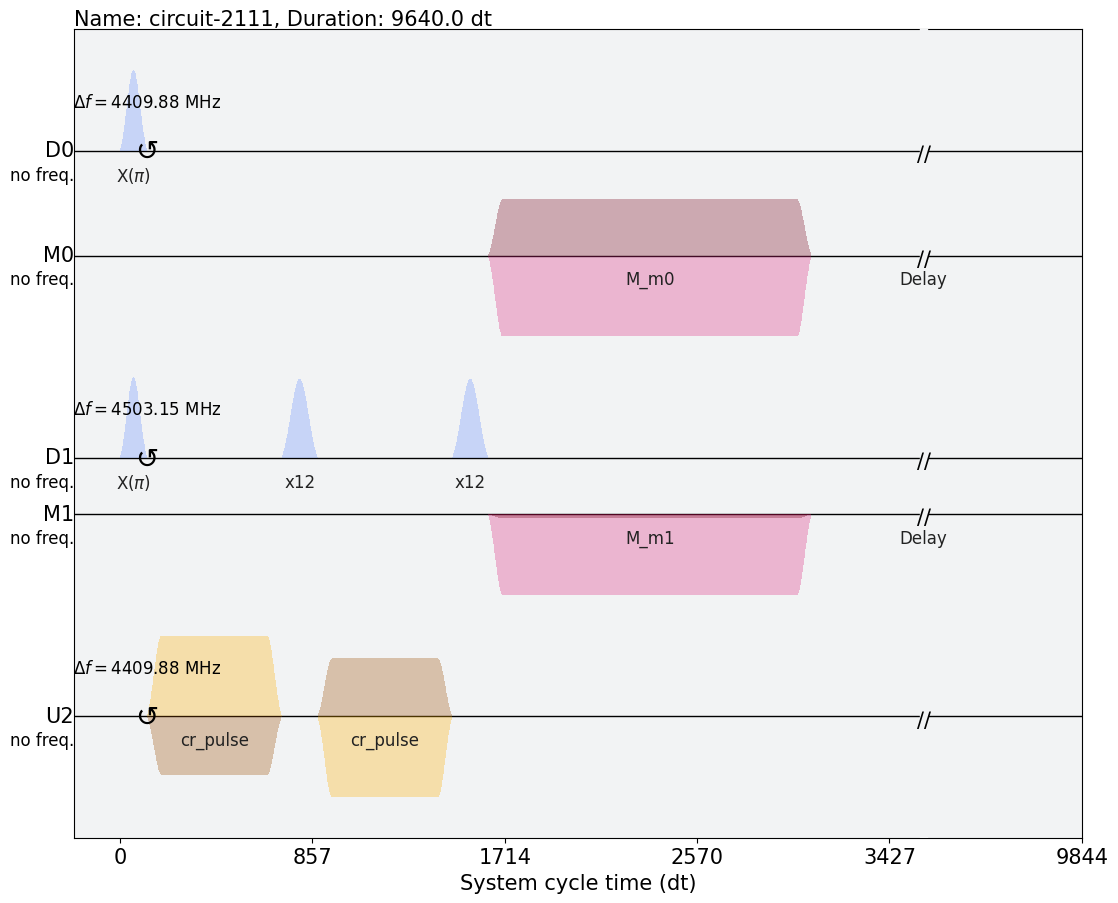

In [449]:
qst_circs, qst_schedules = cr_QST()
qst_schedules[8].draw()

In [435]:
# qst_job = backend.run(qst_circs, meas_level = 1, meas_return = 'single', shots = 4096)

In [489]:
# expectations = {}
# expectations['XX'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
# expectations['XY'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
# expectations['XZ'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
# expectations['YX'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
# expectations['YY'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
# expectations['YZ'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
# expectations['ZX'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
# expectations['ZY'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
# expectations['ZZ'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}


In [505]:
print(expectations)

{'XX': {'00': 6, '01': 27, '02': 68, '10': 66, '11': 869, '12': 1764, '20': 81, '21': 1541, '22': 1767}, 'XY': {'00': 3, '01': 53, '02': 60, '10': 68, '11': 1528, '12': 1382, '20': 82, '21': 1587, '22': 1426}, 'XZ': {'00': 6, '01': 76, '02': 23, '10': 79, '11': 2341, '12': 539, '20': 91, '21': 2489, '22': 545}, 'YX': {'00': 6, '01': 39, '02': 60, '10': 71, '11': 1292, '12': 2268, '20': 60, '21': 1063, '22': 1330}, 'YY': {'00': 2, '01': 44, '02': 56, '10': 68, '11': 1830, '12': 1532, '20': 83, '21': 1241, '22': 1333}, 'YZ': {'00': 5, '01': 73, '02': 25, '10': 89, '11': 2885, '12': 552, '20': 94, '21': 1913, '22': 553}, 'ZX': {'00': 3, '01': 42, '02': 60, '10': 105, '11': 1263, '12': 2086, '20': 42, '21': 1065, '22': 1523}, 'ZY': {'00': 4, '01': 58, '02': 44, '10': 124, '11': 1564, '12': 1823, '20': 48, '21': 1453, '22': 1071}, 'ZZ': {'00': 5, '01': 75, '02': 19, '10': 115, '11': 2824, '12': 583, '20': 46, '21': 2056, '22': 466}}


In [503]:
qst_results = backend.retrieve_job('crwq4ha7jqmg008zqj50').result()

In [504]:

# control_classifier = qubit_classifiers[control_qubit]
# target_classifier = qubit_classifiers[target_qubit]
# for i in range(9):
#     control_iq_data = qst_results.get_memory(i)[:,control_qubit] * scale_factor
#     target_iq_data = qst_results.get_memory(i)[:,target_qubit] * scale_factor
#     control_vals = control_classifier.predict(reshape_complex_vec(control_iq_data))
#     target_vals = target_classifier.predict(reshape_complex_vec(target_iq_data))
#     for j in range(len(control_vals)):
#         q1 = target_vals[j]
#         q2 = control_vals[j]
#         if i == 0:
#             expectations['XX'][str(int(q1))+str(int(q2))]+=1
#         elif i == 1:
#             expectations['XY'][str(int(q1))+str(int(q2))]+=1
#         elif i == 2:
#             expectations['XZ'][str(int(q1))+str(int(q2))]+=1
#         elif i == 3:
#             expectations['YX'][str(int(q1))+str(int(q2))]+=1
#         elif i == 4:
#             expectations['YY'][str(int(q1))+str(int(q2))]+=1
#         elif i == 5:
#             expectations['YZ'][str(int(q1))+str(int(q2))]+=1
#         elif i == 6:
#             expectations['ZX'][str(int(q1))+str(int(q2))]+=1
#         elif i == 7:
#             expectations['ZY'][str(int(q1))+str(int(q2))]+=1
#         elif i == 8:
#             expectations['ZZ'][str(int(q1))+str(int(q2))]+=1



In [510]:
X = np.matrix([[0,1], [1,0]])
Y = np.matrix([[0,-1j],[1j,0]])
Z = np.matrix([[1,0], [0,-1]])
I = np.eye(2)
XX = np.kron(X,X)
XY = np.kron(X,Y)
XZ = np.kron(X,Z)
YX = np.kron(Y,X)
YY = np.kron(Y,Y)
YZ = np.kron(Y,Z)
ZX = np.kron(Z,X)
ZY = np.kron(Z,Y)
ZZ = np.kron(Z,Z)
IX = np.kron(I,X)
IY = np.kron(I,Y)
IZ = np.kron(I,Z)
XI = np.kron(X,I)
YI = np.kron(Y,I)
ZI = np.kron(Z,I)
II = np.kron(I,I)



In [511]:
print(XX)

[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]


In [530]:
pauli_expectations = np.zeros(16)
correction_counts = []
probabilities = {}
probabilities['XX'] = {'11': 0,'12': 0,'21': 0, '22':0}
probabilities['XY'] = {'11': 0,'12': 0,'21': 0, '22':0}
probabilities['XZ'] = {'11': 0,'12': 0,'21': 0, '22':0}
probabilities['YX'] = {'11': 0,'12': 0,'21': 0, '22':0}
probabilities['YY'] = {'11': 0,'12': 0,'21': 0, '22':0}
probabilities['YZ'] = {'11': 0,'12': 0,'21': 0, '22':0}
probabilities['ZX'] = {'11': 0,'12': 0,'21': 0, '22':0}
probabilities['ZY'] = {'11': 0,'12': 0,'21': 0, '22':0}
probabilities['ZZ'] = {'11': 0,'12': 0,'21': 0, '22':0}
print(expectations.keys())
for basis in expectations.keys():
    sum = 0
    for state in expectations[basis]:  
        if '0' in state:
            sum+=expectations[basis][state]      
    correction_counts.append(sum)
for basis in expectations.keys():
    for state in expectations[basis]:  
        if '0' not in state:
            probabilities[basis][state] = expectations[basis][state]/(4096+1024+1024 - correction_counts[list(expectations.keys()).index(basis)])

            

dict_keys(['XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ'])


In [531]:
print(correction_counts)
print(probabilities)

[248, 266, 275, 236, 253, 286, 252, 278, 260]
{'XX': {'11': 0.14738805970149255, '12': 0.29918588873812757, '21': 0.26136363636363635, '22': 0.29969470827679784}, 'XY': {'11': 0.25995236474991495, '12': 0.23511398434841782, '21': 0.26998979244641036, '22': 0.24259952364749915}, 'XZ': {'11': 0.3988754472652922, '12': 0.09183847333446925, '21': 0.4240926904072244, '22': 0.09286079400238542}, 'YX': {'11': 0.21868652674339878, '12': 0.38388625592417064, '21': 0.17992552471225456, '22': 0.22511848341232227}, 'YY': {'11': 0.31064335426922424, '12': 0.2600577151587167, '21': 0.21066032931590561, '22': 0.22627737226277372}, 'YZ': {'11': 0.4924889040628201, '12': 0.09423011266643906, '21': 0.32656196654148173, '22': 0.09440081939228405}, 'ZX': {'11': 0.21435845213849286, '12': 0.35403937542430414, '21': 0.18075356415478616, '22': 0.25848608282416835}, 'ZY': {'11': 0.2666212069553358, '12': 0.31077395158540744, '21': 0.24769860211387656, '22': 0.18257756563245822}, 'ZZ': {'11': 0.479945615227736

In [538]:
probabilities['IX'] = {'11': probabilities['XX']['11'], '12': probabilities['XX']['12'], 
                    '21': probabilities['XX']['22'], '22': probabilities['XX']['21']}
probabilities['XI'] = {'11': probabilities['XX']['11'], '12': probabilities['XX']['22'], 
                    '21': probabilities['XX']['21'], '22': probabilities['XX']['12']}
probabilities['IY'] = {'11': probabilities['YY']['11'], '12': probabilities['YY']['12'], 
                    '21': probabilities['YY']['22'], '22': probabilities['YY']['21']}
probabilities['YI'] = {'11': probabilities['YY']['11'], '12': probabilities['YY']['22'], 
                    '21': probabilities['YY']['21'], '22': probabilities['YY']['12']}
probabilities['IZ'] = {'11': probabilities['ZZ']['11'], '12': probabilities['ZZ']['12'], 
                    '21': probabilities['ZZ']['22'], '22': probabilities['ZZ']['21']}
probabilities['ZI'] = {'11': probabilities['ZZ']['11'], '12': probabilities['ZZ']['22'], 
                    '21': probabilities['ZZ']['21'], '22': probabilities['ZZ']['12']}

In [539]:
final_expectations = []
for basis in probabilities.keys():
    trace = 0
    for state in probabilities[basis]:
        if state == '11' or state == '22':
            trace += probabilities[basis][state]
        else:
            trace -= probabilities[basis][state]
    final_expectations.append(trace)
print(final_expectations)

[-0.11346675712347354, -0.002551888397414076, -0.02419492247401603, -0.12000677048070413, 0.06620268205737567, 0.16609764424718337, -0.06194840461642909, -0.10927378111148997, 0.11063902107409922, -0.1901289009497965, -0.11448439620081408, 0.034968596163639454, 0.13376336784926157, 0.6510876954452753, 0.15040788579197822]


In [627]:
pauli_matrices = [II,XX, XY,XZ,YX,YY,YZ,ZX,ZY,ZZ,IX,XI,IY,YI,IZ,ZI]
experimental_state = II
for i in range(len(final_expectations)):
    experimental_state = np.add(experimental_state, final_expectations[i]*pauli_matrices[i+1])
experimental_state/=4
print(experimental_state)

[[ 0.47803365+0.j         -0.06301933+0.0185763j  -0.03466983-0.07496525j
  -0.07328405+0.03063966j]
 [-0.06301933-0.0185763j   0.09717029+0.j         -0.04018271+0.02936372j
  -0.02257237+0.00808357j]
 [-0.03466983+0.07496525j -0.04018271-0.02936372j  0.3475102 +0.j
  -0.03204512-0.03606059j]
 [-0.07328405-0.03063966j -0.02257237-0.00808357j -0.03204512+0.03606059j
   0.07728586+0.j        ]]


In [628]:
ideal_state = np.matrix([[0.5,0,0,0], [0,0,0,0], [0,0,0.5,0], [0,0,0,0]])
state_fidelity = np.sqrt(np.multiply(np.sqrt(ideal_state),np.multiply(experimental_state, np.sqrt(ideal_state))))
np.trace(state_fidelity)**2

(0.8203520609560415+0j)

In [457]:
def qpt():
    circs = []
    schedules = []
    cr_gate = Gate('cr_gate', 2, [])
    for target_state_type in [0,1,2,3]:
        for control_state_type in [0,1,2,3]:
            for target_basis in ['X','Y','Z']:
                for control_basis in ['X','Y','Z']:
                    circ = QuantumCircuit(2,2)
                    circ.x(0)
                    circ.x(1)
                    cr_sched = qpt_cr_pulse_sequence(control_basis, target_basis, cr_amp, cr_duration, cr_square_width, cr_phase, target_state_type, control_state_type)
                    circ.append(cr_gate, [control_qubit, target_qubit])
                    circ.add_calibration(cr_gate, (control_qubit, target_qubit), cr_sched, [])
                    circ.measure(0,0)
                    circ.measure(1,1)
                    circ = transpile(circ, backend = backend, optimization_level = 1)
                    circs.append(circ)
                    schedules.append(schedule(circ, backend = backend))
    return circs, schedules

In [458]:
qpt_circs, qpt_scheds = qpt()

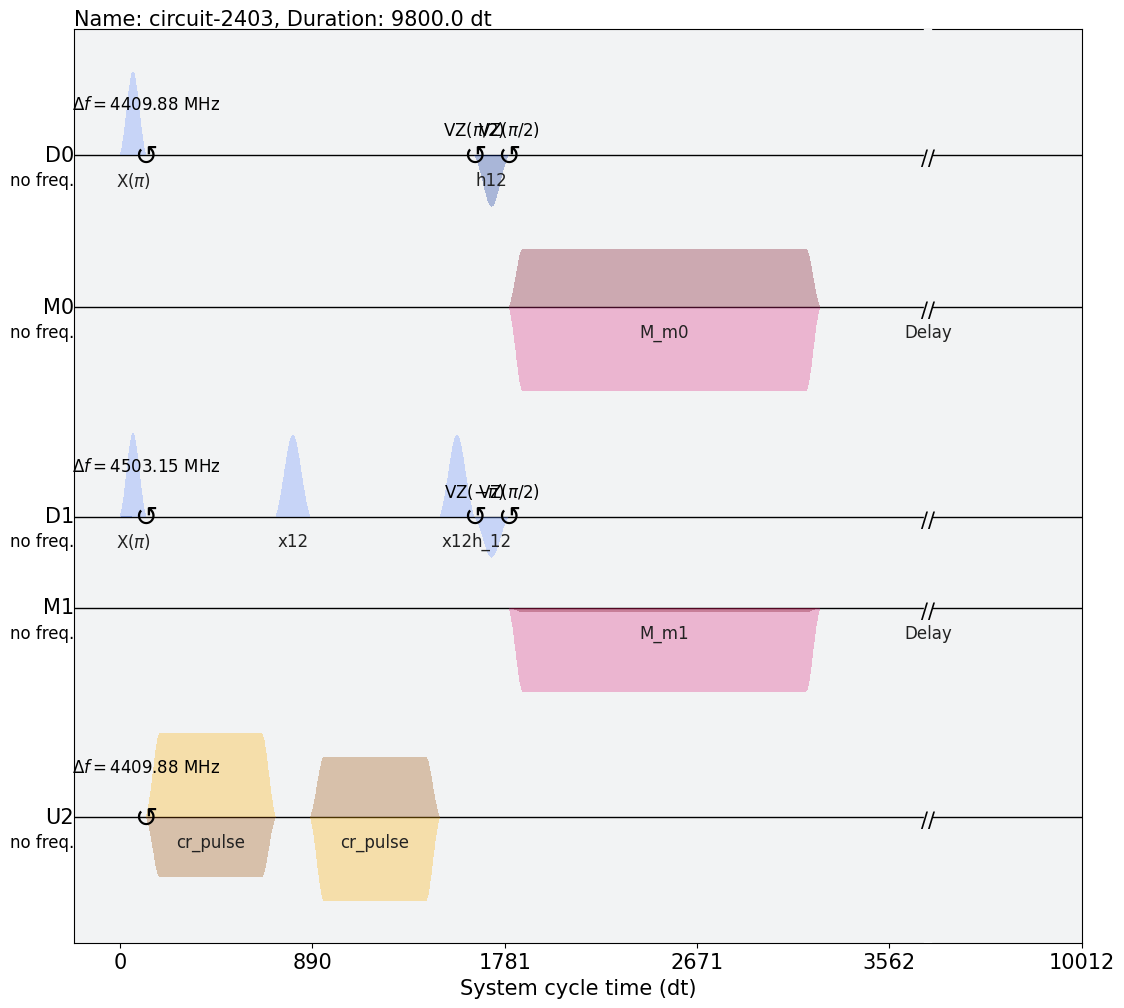

In [561]:
qpt_scheds[1].draw()

In [506]:
# qpt_job = backend.run(qpt_circs, meas_level = 1, meas_return = 'single', shots = 1024)

In [ ]:
qpt_expectations = {}
qpt_expectations['XX'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
qpt_expectations['XY'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
qpt_expectations['XZ'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
qpt_expectations['YX'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
qpt_expectations['YY'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
qpt_expectations['YZ'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
qpt_expectations['ZX'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
qpt_expectations['ZY'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
qpt_expectations['ZZ'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}


In [547]:
qpt_results = backend.retrieve_job('crwqtd9x484g008fdnxg').result()
qpt_results2 = backend.retrieve_job('crwqtehy7jt00080az4g').result()
qpt_results3 = backend.retrieve_job('crwqtgjhazpg0084a70g').result()
qpt_results4 = backend.retrieve_job('crwr3enx484g008fdq5g').result()

In [604]:
def qst_matrix(round):
    qst_expectations = {}
    qst_expectations['XX'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
    qst_expectations['XY'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
    qst_expectations['XZ'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
    qst_expectations['YX'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
    qst_expectations['YY'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
    qst_expectations['YZ'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
    qst_expectations['ZX'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
    qst_expectations['ZY'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}
    qst_expectations['ZZ'] = {'00': 0,'01': 0,'02': 0,'10': 0, '11': 0,'12': 0,'20': 0,'21': 0, '22':0}

    control_classifier = qubit_classifiers[control_qubit]
    target_classifier = qubit_classifiers[target_qubit]
    for i in range(9*(round-1), 9*round):
        control_iq_data = qpt_results.get_memory(i)[:,control_qubit] * scale_factor
        control_iq_data2 = qpt_results2.get_memory(i)[:,control_qubit] * scale_factor
        control_iq_data3 = qpt_results3.get_memory(i)[:,control_qubit] * scale_factor
        control_iq_data4 = qpt_results4.get_memory(i)[:,control_qubit] * scale_factor
        target_iq_data = qpt_results.get_memory(i)[:,target_qubit] * scale_factor
        target_iq_data2 = qpt_results2.get_memory(i)[:,target_qubit] * scale_factor
        target_iq_data3 = qpt_results3.get_memory(i)[:,target_qubit] * scale_factor
        target_iq_data4 = qpt_results4.get_memory(i)[:,target_qubit] * scale_factor
        control_vals = control_classifier.predict(reshape_complex_vec(control_iq_data))
        control_vals2 = control_classifier.predict(reshape_complex_vec(control_iq_data2))
        control_vals3 = control_classifier.predict(reshape_complex_vec(control_iq_data3))
        control_vals4 = control_classifier.predict(reshape_complex_vec(control_iq_data4))
        control_vals = np.concatenate((control_vals,control_vals2, control_vals3, control_vals4), axis = None)
        target_vals = target_classifier.predict(reshape_complex_vec(target_iq_data))
        target_vals2 = control_classifier.predict(reshape_complex_vec(target_iq_data2))
        target_vals3 = control_classifier.predict(reshape_complex_vec(target_iq_data3))
        target_vals4 = control_classifier.predict(reshape_complex_vec(target_iq_data4))
        target_vals = np.concatenate((target_vals,target_vals2, target_vals3, target_vals4), axis = None)
        for j in range(len(control_vals)):
            q1 = target_vals[j]
            q2 = control_vals[j]
            if i%9== 0:
                qst_expectations['XX'][str(int(q1))+str(int(q2))]+=1
            elif i%9 == 1:
                qst_expectations['XY'][str(int(q1))+str(int(q2))]+=1
            elif i%9 == 2:
                qst_expectations['XZ'][str(int(q1))+str(int(q2))]+=1
            elif i%9 == 3:
                qst_expectations['YX'][str(int(q1))+str(int(q2))]+=1
            elif i%9 == 4:
                qst_expectations['YY'][str(int(q1))+str(int(q2))]+=1
            elif i%9 == 5:
                qst_expectations['YZ'][str(int(q1))+str(int(q2))]+=1
            elif i%9 == 6:
                qst_expectations['ZX'][str(int(q1))+str(int(q2))]+=1
            elif i%9 == 7:
                qst_expectations['ZY'][str(int(q1))+str(int(q2))]+=1
            elif i%9 == 8:
                qst_expectations['ZZ'][str(int(q1))+str(int(q2))]+=1
    correction_counts = []
    probabilities = {}
    probabilities['XX'] = {'11': 0,'12': 0,'21': 0, '22':0}
    probabilities['XY'] = {'11': 0,'12': 0,'21': 0, '22':0}
    probabilities['XZ'] = {'11': 0,'12': 0,'21': 0, '22':0}
    probabilities['YX'] = {'11': 0,'12': 0,'21': 0, '22':0}
    probabilities['YY'] = {'11': 0,'12': 0,'21': 0, '22':0}
    probabilities['YZ'] = {'11': 0,'12': 0,'21': 0, '22':0}
    probabilities['ZX'] = {'11': 0,'12': 0,'21': 0, '22':0}
    probabilities['ZY'] = {'11': 0,'12': 0,'21': 0, '22':0}
    probabilities['ZZ'] = {'11': 0,'12': 0,'21': 0, '22':0}
    for basis in qst_expectations.keys():
        sum = 0
        for state in qst_expectations[basis]:  
            if '0' in state:
                sum+=qst_expectations[basis][state]      
        correction_counts.append(sum)
    for basis in qst_expectations.keys():
        for state in qst_expectations[basis]:  
            if '0' not in state:
                probabilities[basis][state] = qst_expectations[basis][state]/(4096 - correction_counts[list(qst_expectations.keys()).index(basis)])
    probabilities['IX'] = {'11': probabilities['XX']['11'], '12': probabilities['XX']['12'], 
                    '21': probabilities['XX']['22'], '22': probabilities['XX']['21']}
    probabilities['XI'] = {'11': probabilities['XX']['11'], '12': probabilities['XX']['22'], 
                        '21': probabilities['XX']['21'], '22': probabilities['XX']['12']}
    probabilities['IY'] = {'11': probabilities['YY']['11'], '12': probabilities['YY']['12'], 
                        '21': probabilities['YY']['22'], '22': probabilities['YY']['21']}
    probabilities['YI'] = {'11': probabilities['YY']['11'], '12': probabilities['YY']['22'], 
                        '21': probabilities['YY']['21'], '22': probabilities['YY']['12']}
    probabilities['IZ'] = {'11': probabilities['ZZ']['11'], '12': probabilities['ZZ']['12'], 
                        '21': probabilities['ZZ']['22'], '22': probabilities['ZZ']['21']}
    probabilities['ZI'] = {'11': probabilities['ZZ']['11'], '12': probabilities['ZZ']['22'], 
                        '21': probabilities['ZZ']['21'], '22': probabilities['ZZ']['12']}
    

    final_expectations = []
    for basis in probabilities.keys():
        trace = 0
        for state in probabilities[basis]:
            if state == '11' or state == '22':
                trace += probabilities[basis][state]
            else:
                trace -= probabilities[basis][state]
        final_expectations.append(trace)
    experimental_state = II
    for i in range(len(final_expectations)):
        experimental_state = np.add(experimental_state, final_expectations[i]*pauli_matrices[i+1])
    experimental_state/=4
    # ideal_state = np.matrix([[0.5,0,0,0], [0,0,0,0], [0,0,0.5,0], [0,0,0,0]])
    # state_fidelity = np.sqrt(np.multiply(np.sqrt(ideal_state),np.multiply(experimental_state, np.sqrt(ideal_state))))
    # state_fidelity = np.trace(state_fidelity)**2
    return experimental_state

In [605]:
print(qst_matrix(2))

[[ 0.0272934 +0.j          0.0298573 +0.00617545j -0.09122971+0.07903053j
  -0.07725022+0.03861929j]
 [ 0.0298573 -0.00617545j  0.09249431+0.j         -0.05160592+0.05164078j
  -0.25992118+0.32273013j]
 [-0.09122971-0.07903053j -0.05160592-0.05164078j  0.18726308+0.j
   0.08165165+0.03962705j]
 [-0.07725022-0.03861929j -0.25992118-0.32273013j  0.08165165-0.03962705j
   0.6929492 +0.j        ]]


In [608]:
def state_fidelity(experimental_state: np.matrix, ideal_state: np.matrix):
    state_fidelity = np.sqrt(np.multiply(np.sqrt(ideal_state),np.multiply(experimental_state, np.sqrt(ideal_state))))
    return np.trace(state_fidelity)**2

In [609]:
e_11 = qst_matrix(1)
e_12 = qst_matrix(2)
# e_1plus = qst_matrix(3)
# e_1minus = qst_matrix(4)
e_21 = qst_matrix(5)
e_22 = qst_matrix(6)
# e_1plus = qst_matrix(3)
# e_1minus = qst_matrix(4)
ideal_state1 =  np.matrix([[0.5,0,0,0], [0,0,0,0], [0,0,0.5,0], [0,0,0,0]])
ideal_state2 = np.matrix([[0,0,0,0], [0,0.5,0,0], [0,0,0,0], [0,0,0,0.5]])
print(state_fidelity(e_11,ideal_state1))
print(state_fidelity(e_12, ideal_state2))
print(state_fidelity(e_21, ideal_state1))
print(state_fidelity(e_22, ideal_state2))

(0.7114274770149219+0j)
(0.6458894131776964+0j)
(0.7086216322443715+0j)
(0.6564284666998679+0j)


In [612]:
print(np.transpose(experimental_state))

[[ 0.47803365+0.j         -0.06301933-0.0185763j  -0.03466983+0.07496525j
  -0.07328405-0.03063966j]
 [-0.06301933+0.0185763j   0.09717029+0.j         -0.04018271-0.02936372j
  -0.02257237-0.00808357j]
 [-0.03466983-0.07496525j -0.04018271+0.02936372j  0.3475102 +0.j
  -0.03204512+0.03606059j]
 [-0.07328405+0.03063966j -0.02257237+0.00808357j -0.03204512-0.03606059j
   0.07728586+0.j        ]]


In [616]:
%pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


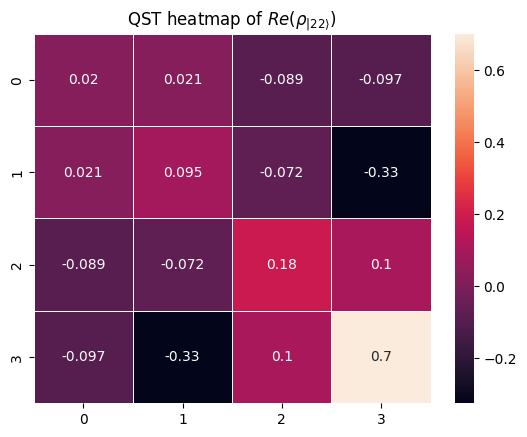

In [646]:
import seaborn as sns
data = e_22
# y = [[ 0.47803365+0.j,-0.06301933-0.0185763j,-0.03466983+0.07496525j,-0.07328405-0.03063966j]
#  [-0.06301933+0.0185763j,0.09717029+0.j, -0.04018271-0.02936372j,-0.02257237-0.00808357j]
#  [-0.03466983-0.07496525j, -0.04018271+0.02936372j,  0.3475102 +0.j,-0.03204512+0.03606059j]
#  [-0.07328405+0.03063966j, -0.02257237+0.00808357j, -0.03204512-0.03606059j, 0.07728586+0.j]]
sns.heatmap(np.real(data), linewidth = 0.5, annot = True)
plt.title('QST heatmap of $Re(\\rho_{\\vert 22\\rangle})$')
plt.show()

Text(0.5, 1.0, 'QST heatmap of $Im(\\rho_{\\vert 22\\rangle})$')

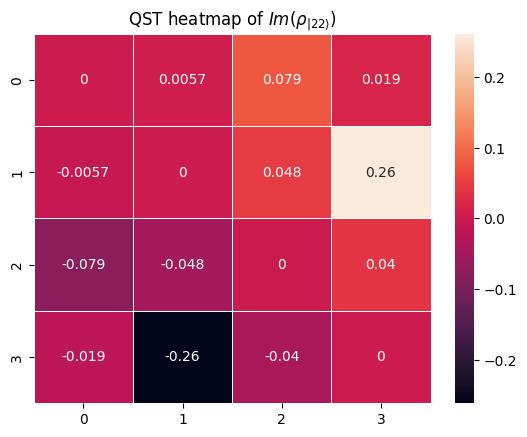

In [647]:
sns.heatmap(np.imag(data), linewidth = 0.5, annot = True)
plt.title('QST heatmap of $Im(\\rho_{\\vert 22\\rangle})$')